In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import xarray as xr
import pandas as pd
import os
import sys
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

print(sys.path)
import pytropd.functions as tropdf
import pytropd.metrics as tropdm
import matplotlib.colors as mcolors

from own_functions import (vertical_weights, weights, calc_jet_lats, calc_jet_lats_tropd,
    max_latitude, calculate_max_lat, calc_theta,
    get_ty_from, get_setup_from, get_l0_from, get_fgamma_from
)
from visualization import (plot_zm_climatologies, plot_transports_intercomp, plot_hor_fields,
    plot_ep_flux_div, plot_EKE_spectral, plot_spectral_vd, plot_hayashi_spectra, 
    plot_wave_persistency, plot_theta_u_zm_clim, plot_u_jets_intercomp, plot_jet_metrics,
    plot_jet_contours_intercomp, plot_eke_contours_intercomp, plot_psi_intercomp,
    plot_psi_contours_intercomp, plot_lines_tp_height_intercomp, plot_tp_height_intercomp
)
from own_functions import r_air, kappa, kappai, g0, p00, r_e, omega_earth
from tropopause import tropopause_ds, tropopause_profile, tropopause_ds_time_mean

pplt.rc.update({
    'figure.dpi': 100,
    'figure.figsize': (8,6),
    'savefig.dpi': 150,
})

['/home/b/b381739/masterarbeit', '/home/b/b381739/masterarbeit', '/home/b/b381739/code', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python39.zip', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/lib-dynload', '', '/home/b/b381739/.local/lib/python3.9/site-packages', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages']


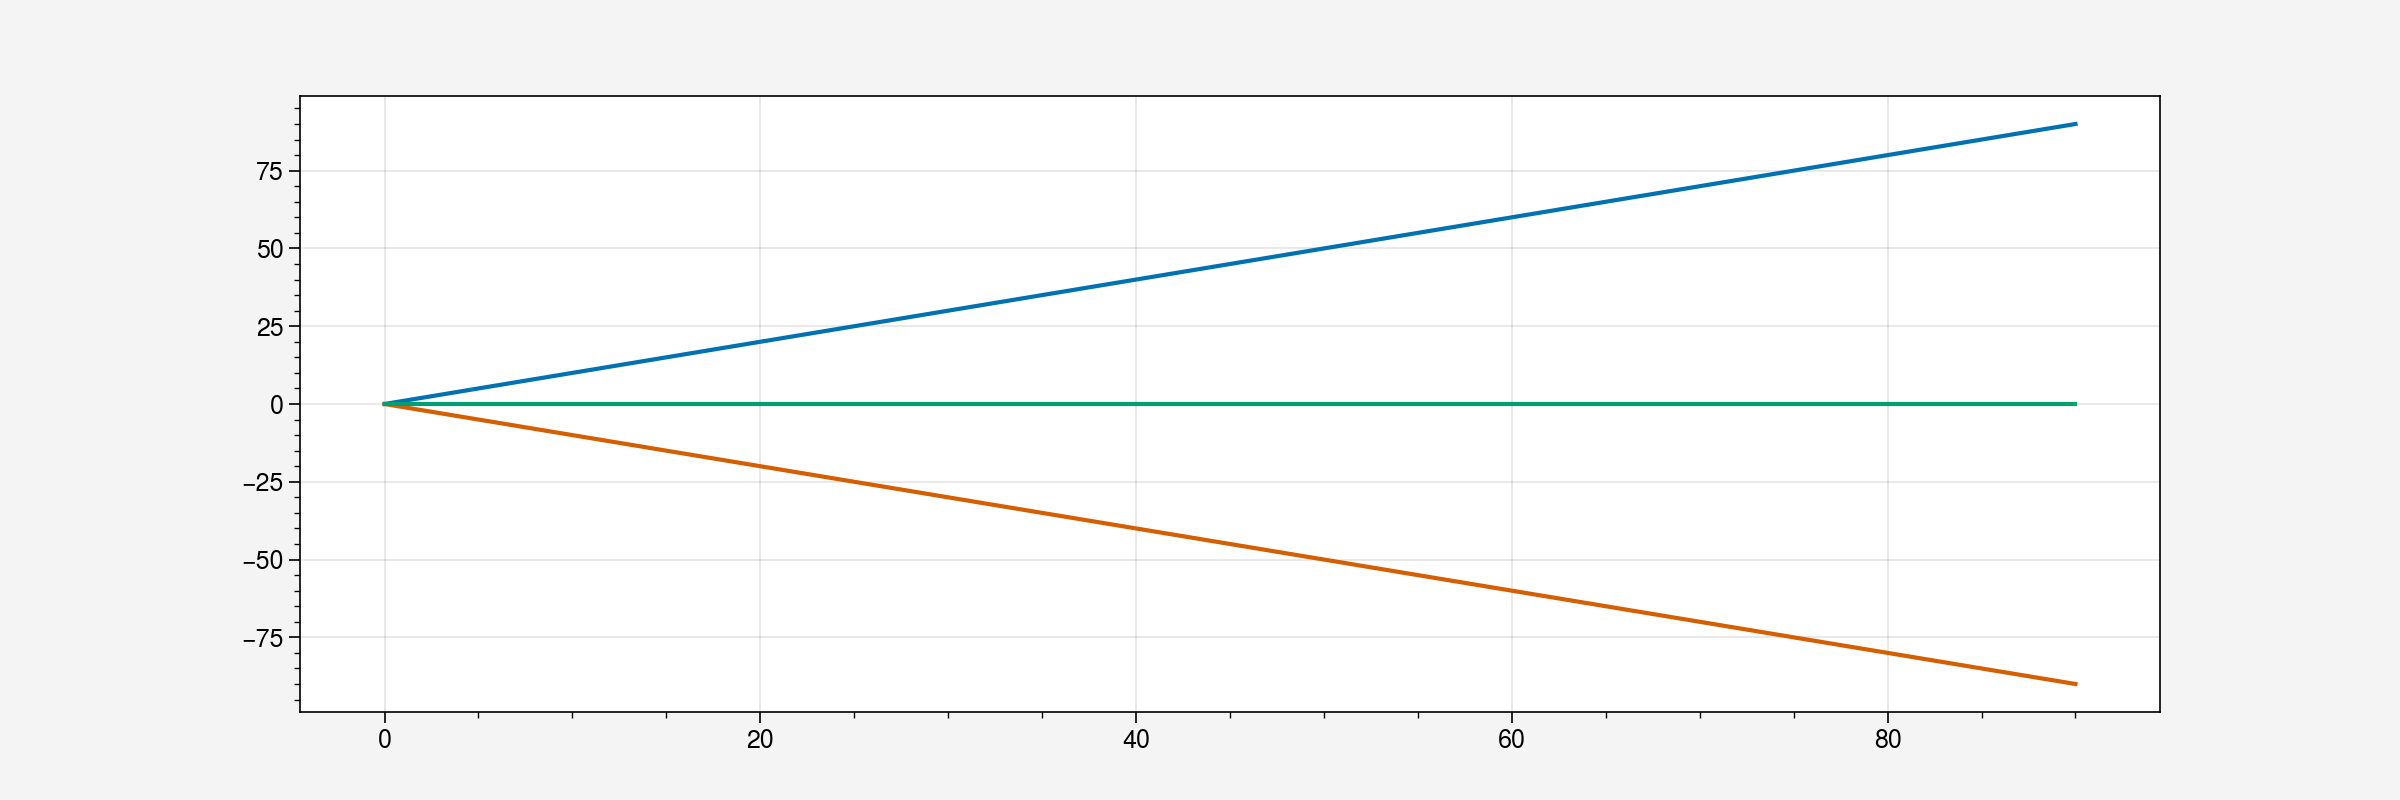

In [2]:
# average between hemispheres
#foo = xr.DataArray(np.random.normal(size=181), coords={"lat": np.arange(-90, 91)})
foo = xr.DataArray(np.arange(-90, 91), dims=['lat'], coords={"lat": np.arange(-90, 91)})

fig, ax = plt.subplots(figsize=(12,4))
foo_hm = foo.groupby(np.abs(foo.lat)).mean()

plt.plot(foo.lat.sel(lat=slice(0,90)), foo.sel(lat=slice(0,90)))
plt.plot(foo.lat.sel(lat=slice(0,90)), np.flipud(foo.sel(lat=slice(-90,0))))
plt.plot(foo_hm.lat, foo_hm)

## Setup

In [10]:
#exp_names = ['EMIL_HSl6_dy20', 'EMIL_HSl6_dy40', 'EMIL_HSl6_dy60', 'EMIL_HSl6_dy80', 'EMIL_HSl6_dy_C'] 
#exp_names = ['EMIL_SW06_dy80', 'EMIL_SW06_dy60', 'EMIL_SW06_rfsc']
# 'EMIL_SW06_f077',
#"""
exp_names = ['EMIL_SW90_f050', 'EMIL_SW90_f055', 'EMIL_SW90_f060', 'EMIL_SW90_f065', 'EMIL_SW90_f067', 'EMIL_SW90_f070',
             'EMIL_SW90_f072', 'EMIL_SW90_f075', 'EMIL_SW90_f077', 'EMIL_SW90_f080', 'EMIL_SW90_f082', 'EMIL_SW90_f085',
             'EMIL_SW90_f090', 'EMIL_SW90_f100'] #, 'EMIL_SW06_fg09']
#"""
#exp_names = ['EMIL_SW80_f070', 'EMIL_SW80_f075', 'EMIL_SW80_f080']
#exp_names = ['EMIL_PKSW_ts01', 'EMIL_PKSW_ts02', 'EMIL_SW90_f070']
#exp_names = ['EMIL_SW90_f070', 'EMIL_SW90_f080']
#exp_names = ['W2h85SW90_f070', 'W2h85SW90_f080']

#exp_names.append('EMIL_vareps_00')
ylims=[1013,10]
plot_format = 'png'

work_path = '/work/bd1022/b381739'
home_path = '/home/b/b381739/'
ref_name =   'EMIL_HSl0_dy60'
outpath = f'{home_path}/plots' 
csv_path = f'{home_path}/masterarbeit'

linestyles = ['solid', (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1)), 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 'dotted', (0, (1, 2)), (0, (5, 8))]
alternation_colors = ['gray', 'black']
colors = list(mcolors.TABLEAU_COLORS)
alt_cols=mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in alt_cols.items())
alt_colors = [name for hsv, name in by_hsv][14::6]

def load_datasets(exp_names, ending, streamfunction=False):
    
    ds_list = []
    
    for exp_name in exp_names:
        inpath = f'{work_path}/{exp_name}/postprocessed'
        os.chdir(inpath)
        ds = xr.open_dataset(f'{exp_name}_{ending}.nc') #.sortby('time')
        ds['exp_name'] = [exp_name]
        if streamfunction == True:
            # calculate streamfunction
            psi = tropdf.TropD_Calculate_StreamFunction(ds.mean('time').vm1.values.T, 
                                                ds.lat.values,
                                                ds.plev.values)
            ds['psi'] = (['plev', 'lat'], psi.T)

        ds_list.append(ds)
    
    ds_comb = xr.concat(ds_list, 'exp_name', coords='minimal', compat='override')
    return ds_comb

def setup_diagnostic_dataframe(exp_names):
    df_diagn = pd.read_csv(f'{csv_path}/diagnostics.csv', index_col=[0,1])
    
    for exp_name in exp_names:
        if exp_name in df_diagn.index:
            print(f'{exp_name} already in index')
        else:
            df_diagn.loc[(exp_name,'NH'),] = np.nan
            df_diagn.loc[(exp_name,'SH'),] = np.nan

    return df_diagn

def calc_Ty_eff(setup, ty, l0, lat, eps=None):
    """
    pass lat as DataArray
    """
    t1 = 315 - 273.15
    if setup == 'HS':
        if eps is None:
            eps = - ty * 2 * np.sin(np.radians(l0))
        else:
            l0 = np.rad2deg(np.arcsin(-eps/(2*ty)))
        
    if setup == 'HS':
        t_sfc = t1 - ty * np.sin(np.radians(lat))**2 - eps * np.sin(np.radians(lat))
    elif setup == 'SW':
        t_sfc = t1 - ty * (np.sin(np.radians(lat))**2 - 2*np.sin(np.radians(l0))*np.sin(np.radians(lat)))
        

    ty_eff_nh = t_sfc.interp(lat=l0).values - t_sfc.interp(lat=90, kwargs={"fill_value": "extrapolate"}).values
    ty_eff_sh = t_sfc.interp(lat=l0).values - t_sfc.interp(lat=-90, kwargs={"fill_value": "extrapolate"}).values
    return ty_eff_nh, ty_eff_sh, t_sfc

ds_zm = load_datasets(exp_names, 'zm_pp', streamfunction=True)
ds_tp = load_datasets(exp_names, 'transports_int_pp')
ds_pcs = load_datasets(exp_names, 'pcs')
ds_eofs = load_datasets(exp_names, 'eofs')

os.chdir(outpath)

vert_weights = vertical_weights(ds_zm.sel(exp_name=exp_names[0]))
full_weights = weights(ds_zm.sel(exp_name=exp_names[0]))

ds_zm['theta'] = calc_theta(ds_zm)
ds_zm

ds_zm = tropopause_ds_time_mean(ds_zm)
ds_zm

<xarray.Dataset>
Dimensions:         (exp_name: 14, lat: 64, plev: 90, time: 366)
Coordinates:
  * plev            (plev) float32 0.009946 0.03183 0.05808 ... 995.7 1.009e+03
  * time            (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * lat             (lat) float32 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
  * exp_name        (exp_name) <U14 'EMIL_SW90_f050' ... 'EMIL_SW90_f100'
Data variables: (12/14)
    um1             (exp_name, lat, time, plev) float32 0.02044 0.02286 ... nan
    vm1             (exp_name, lat, time, plev) float32 -0.1411 0.05783 ... nan
    vervel          (exp_name, lat, time, plev) float32 -6.405e-07 ... nan
    tm1             (exp_name, lat, time, plev) float32 200.9 198.6 ... nan nan
    aps             (exp_name, lat, time) float32 9.954e+04 ... 9.949e+04
    geopot_p        (exp_name, lat, time, plev) float32 6.823e+05 ... nan
    ...              ...
    theta           (exp_name, lat, time, plev) float32 5.447e+03 ... nan
    height          (exp_name, lat, time, plev) float32 6.957e+04 ... nan
    ttp             (exp_name, lat) float64 202.2 202.0 201.8 ... 213.2 213.2
    ptp             (exp_name, lat) float64 192.8 191.1 188.6 ... 321.9 322.2
    ztp             (exp_name, lat) float64 1.075e+04 1.08e+04 ... 7.822e+03
    thickness_flag  (exp_name, lat) float64 0.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 1.0

In [20]:
ds_pcs

<xarray.Dataset>
Dimensions:   (exp_name: 14, mode: 366, time: 366)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * mode      (mode) int64 0 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * exp_name  (exp_name) <U14 'EMIL_SW90_f050' ... 'EMIL_SW90_f100'
Data variables:
    pcs       (exp_name, time, mode) float32 -0.08374 0.4827 ... -0.2299 -0.9986

EMIL_SW90_f050's effective sample size: 0.5618162467187163
EMIL_SW90_f055's effective sample size: 9.279517725550349
EMIL_SW90_f060's effective sample size: 5.713528016330031
EMIL_SW90_f065's effective sample size: 6.5653337833023615
EMIL_SW90_f067's effective sample size: 8.67454546043191
EMIL_SW90_f070's effective sample size: 7.5144813909612616
EMIL_SW90_f072's effective sample size: 4.410926383660265
EMIL_SW90_f075's effective sample size: 0.9394136021596026
EMIL_SW90_f077's effective sample size: 3.1123863748291343
EMIL_SW90_f080's effective sample size: 3.016470046284852
EMIL_SW90_f082's effective sample size: 6.847170612498846
EMIL_SW90_f085's effective sample size: 2.2617636142622946
EMIL_SW90_f090's effective sample size: 4.864149346472293
EMIL_SW90_f100's effective sample size: 2.6198571631077003


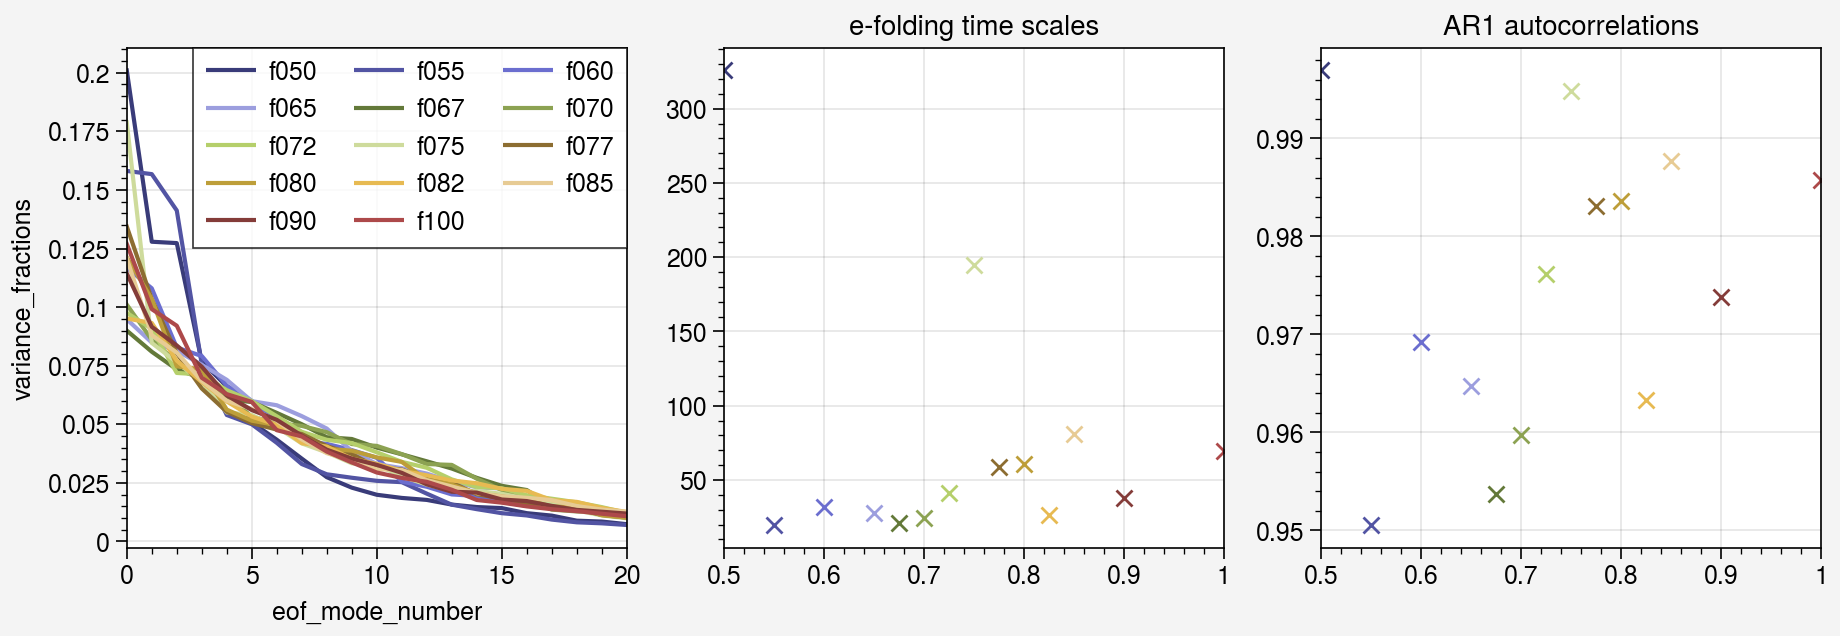

In [99]:
fig, ax = pplt.subplots(ncols=3, cycle='tab20b', share=False)

n_eff = np.zeros(len(exp_names))

for j, exp_name in enumerate(exp_names):
    ds = ds_eofs.sel(mode=slice(0,20), exp_name=exp_name)
    pc = ds_pcs.pcs.sel(mode=0, exp_name=exp_name)
    dt = 1 # days 
    
    fg = get_fgamma_from(exp_name)
    ax[0].plot(ds.mode, ds.var_exp, label=f'{exp_name[-4:]}')

    r_a1pc = 0.5 * np.corrcoef(pc.values[1:], pc.values[:-1])[1,0] + 0.5 * np.corrcoef(pc.values[1:], pc.values[:-1])[1,0] ** 0.5
    ax[1].plot(fg, - dt/np.log(r_a1pc), 'x')
    ax[2].plot(fg,  r_a1pc, 'x')    
    #print(f'autocorrelation PC {1}: {r_a1pc} \n e-folding time: {- dt/np.log(r_a1pc):.3} days')
    n_eff[j] = pc.time.size * (1 - r_a1pc)/(1 + r_a1pc)

ax[0].legend()
ax[1].set_title('e-folding time scales')
ax[2].set_title('AR1 autocorrelations')

for i in range(len(exp_names)):
    print(f'{exp_names[i]}\'s effective sample size: {n_eff[i]}')
    
fig.savefig(f'Intercomparison_eofs_var_exp_time_scales.{plot_format}')

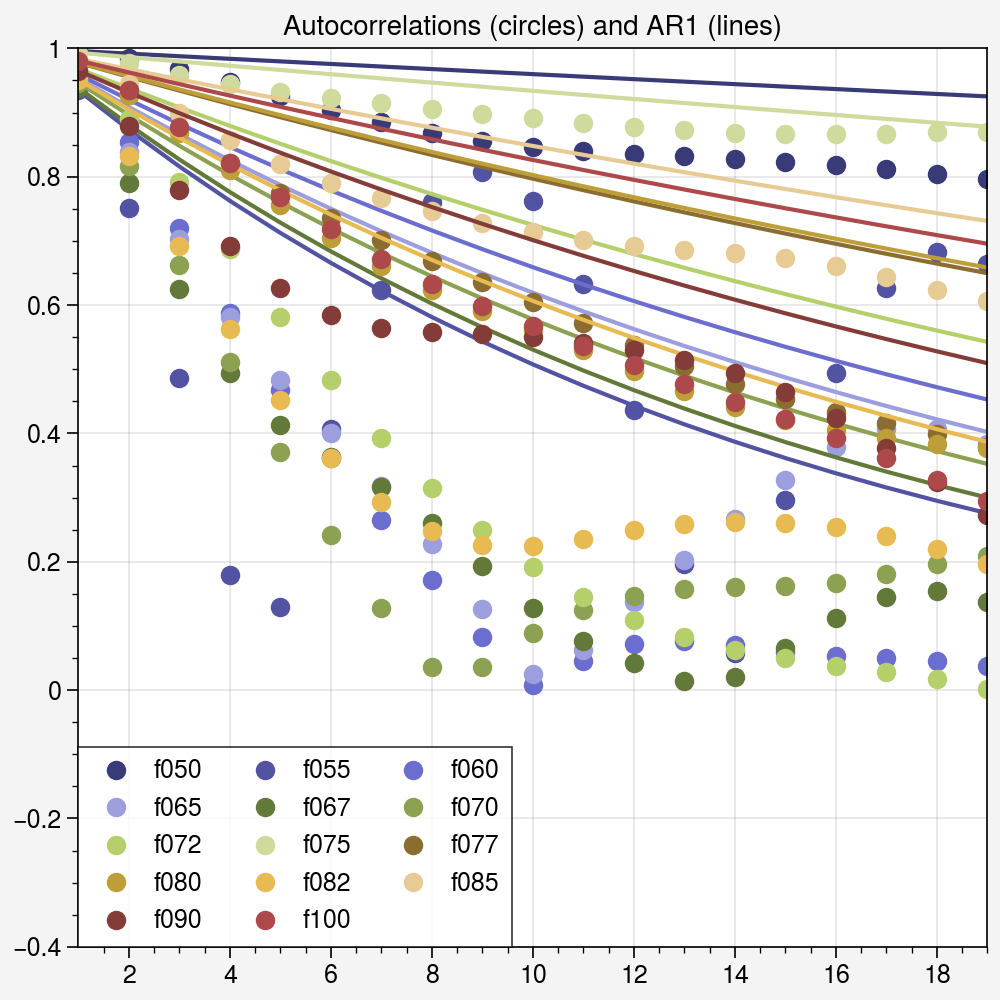

In [100]:
fig, ax  = pplt.subplots(figsize=(5,5), cycle='tab20b')
lag_range = range(1, 20)

for exp_name in exp_names:
    pc = ds_pcs.pcs.sel(mode=0, exp_name=exp_name)
    r_lag = [np.abs(np.corrcoef(pc.values[i:], pc.values[:-i])[1,0]) for i in lag_range]
    r_lag_alt = [0.5 * np.abs(np.corrcoef(pc.values[i:], pc.values[:-i])[1,0]) + 0.5 * np.abs(np.corrcoef(pc.values[i+1:], pc.values[:-(i+1)])[1,0]) ** 0.5 for i in lag_range]
    fg = get_fgamma_from(exp_name)

    color=next(ax[0]._get_lines.prop_cycler)['color']
    ax.plot(lag_range, r_lag, 'o', label=f'{exp_name[-4:]}', color=color)
    ax.plot(lag_range, r_lag[0] ** lag_range, color=color)


ax.set_ylim([-0.4, 1])
ax.legend()
ax.set_title('Autocorrelations (circles) and AR1 (lines)')

fig.savefig(f'Intercomparison_eofs_autocorr.{plot_format}')

In [4]:
def calculate_supercriticality(ds):
    
    lat_ref = 45
    bc_zone = [30, 50]
    p_zone = [700,800]
    
    ds_sel = ds.sel(lat = slice(bc_zone[0], bc_zone[1]))
    
    f_ref = 2 * omega_earth * np.sin(np.radians(lat_ref))
    beta_ref = (2 * omega_earth * np.cos(np.radians(lat_ref)))/r_e
    
    surf_theta_dp = (ds_sel.theta.sel(plev = p_zone[0]) -
                     ds_sel.theta.sel(plev = p_zone[1].values)).mean('time')
    
    bulk_stability = (2 * surf_theta_dp * (ds_sel.aps.mean('time') - ds_sel.ttp.mean('time')) * np.cos(np.radians(ds_sel.lat))).mean('lat')
    
    return bulk_stability, supercriticality

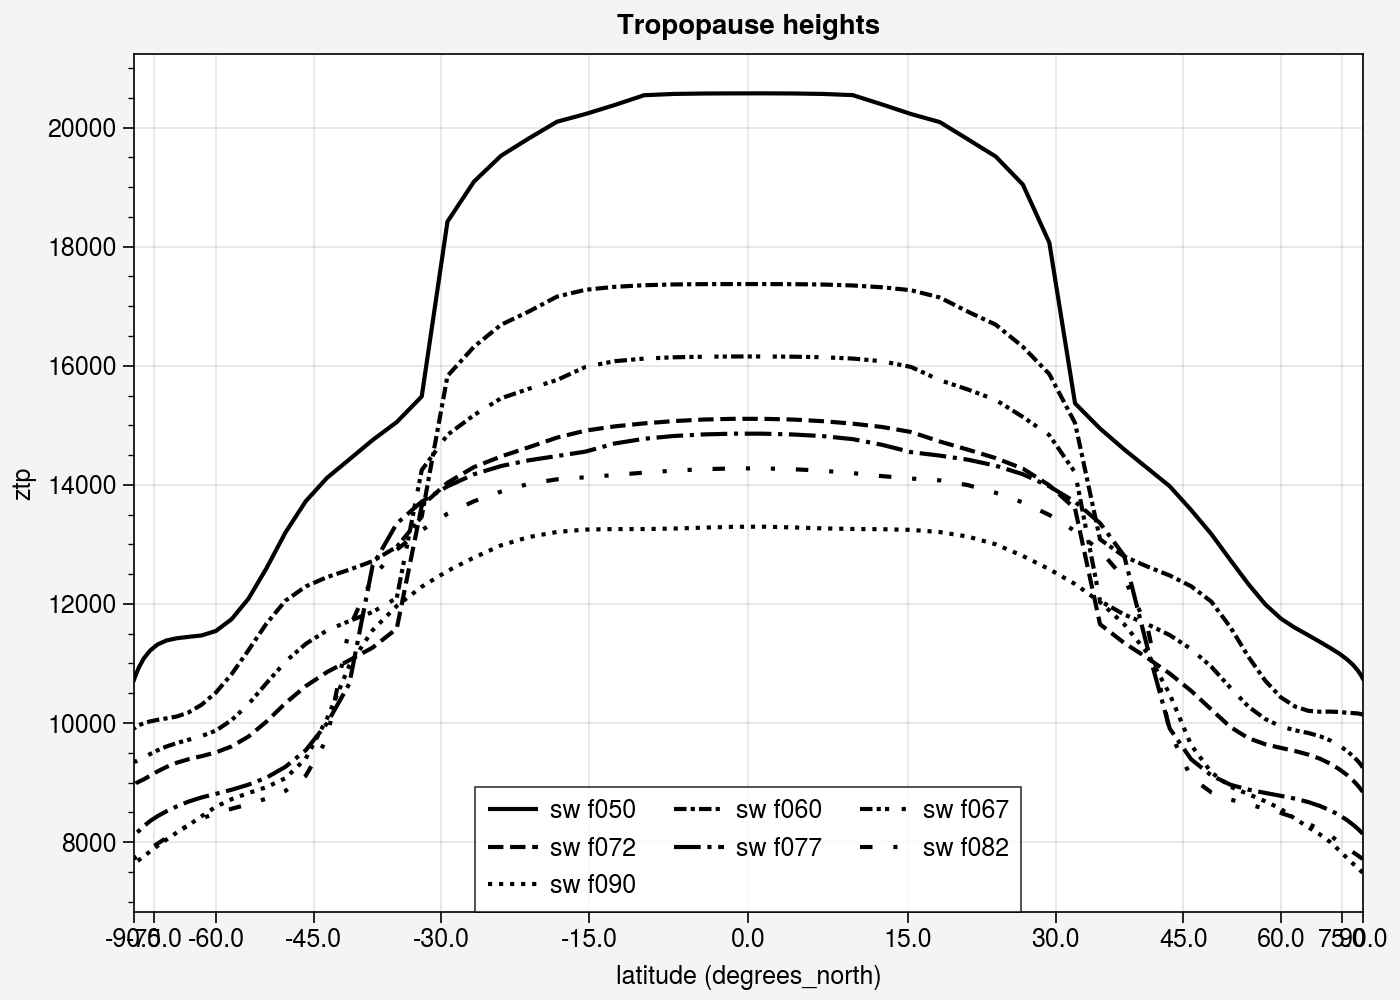

In [15]:
fig, ax = pplt.subplots(nrows = 1, ncols = 1, figsize = (7,5), figtitle='Tropopause heights')

for i,en in enumerate(exp_names[::2]):
    fig, ax = plot_lines_tp_height_intercomp(ds_zm.sel(exp_name=en), fig=fig, ax=ax,
                                             linestyle=linestyles[i],
                                       )
fig.show()
fig.savefig(f'Intercomparison_ztp_lines.{plot_format}')

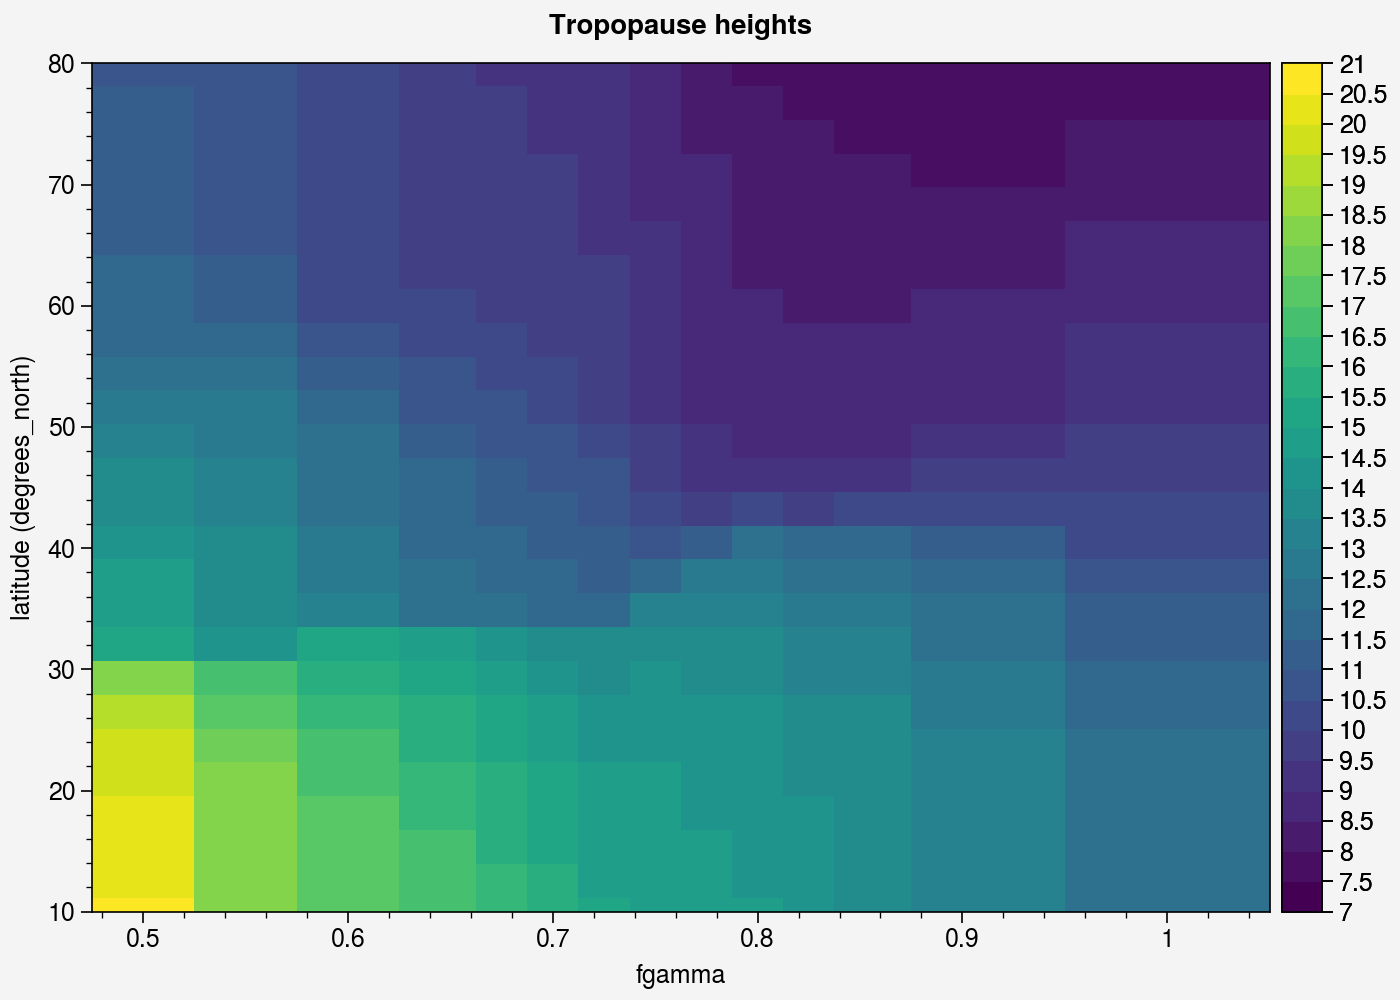

In [16]:
fig, ax = plot_tp_height_intercomp(ds_zm, exp_names)
fig.savefig(f'Intercomparison_ztp.{plot_format}')

['rosybrown',
 'darkred',
 'coral',
 'saddlebrown',
 'darkorange',
 'papayawhip',
 'darkgoldenrod',
 'palegoldenrod',
 'olive',
 'chartreuse',
 'forestgreen',
 'mediumseagreen',
 'turquoise',
 'darkslategray',
 'darkturquoise',
 'lightskyblue',
 'slategray',
 'lavender',
 'slateblue',
 'indigo',
 'violet',
 'mediumvioletred',
 'pink']

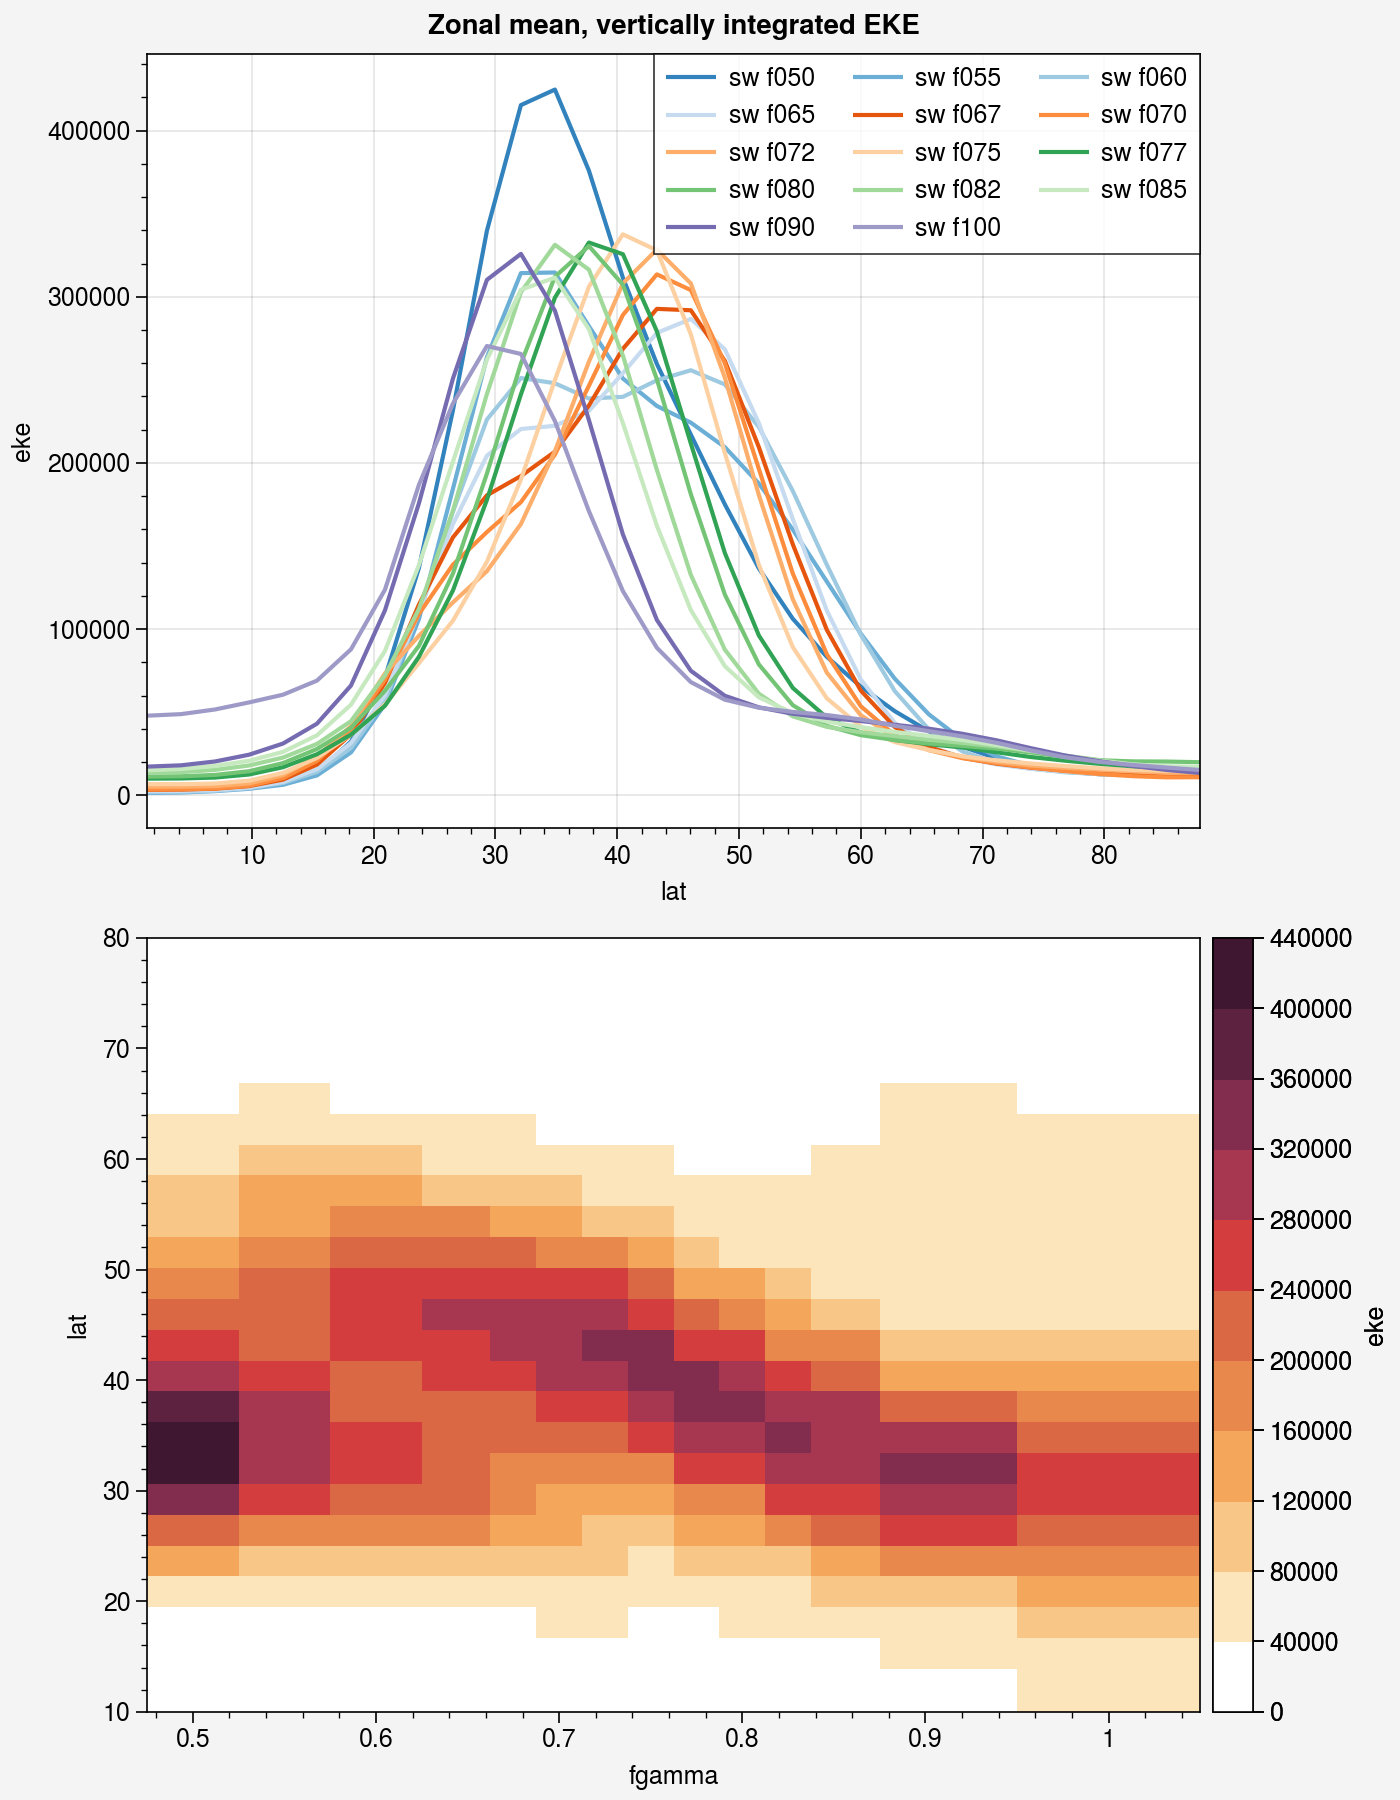

In [45]:
def plot_eke_int_intercomp(ds_zm, exp_names, fig=None, ax=None,  p0=50, p1=1000, linestyle='solid'):
    
    if fig is None:
        fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Zonal mean, vertically integrated EKE', share=False)

    ds = ds_zm.sel(plev=slice(p0,p1)).mean('time').groupby(np.abs(ds_zm.lat)).mean()
    weights = vertical_weights(ds)
    lats = ds.lat
    fgs = np.array([get_fgamma_from(en) for en in exp_names])
    
    eke = ds.eke.weighted(weights).sum('plev')

    for en in exp_names:
        setup = get_setup_from(en).lower()
        label = f'{setup} {en[-4:]}'
        ax[0].plot(ds.lat, ds.sel(exp_name=en).eke.weighted(weights).sum('plev'),
                   cycle='tab20c', linestyle=linestyle, label=label)
    ax[1].pcolormesh(fgs, lats, eke, colorbar='right')

    ax[0].legend()

    ax[1].set_xlabel('fgamma')
    ax[1].set_ylim([10, 80])
    
    return fig, ax 

fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Zonal mean, vertically integrated EKE', share=False)

fig, ax = plot_eke_int_intercomp(ds_zm, exp_names, fig=fig, ax=ax)
    
fig.savefig(f'Intercomparison_vert_int_eke.{plot_format}')

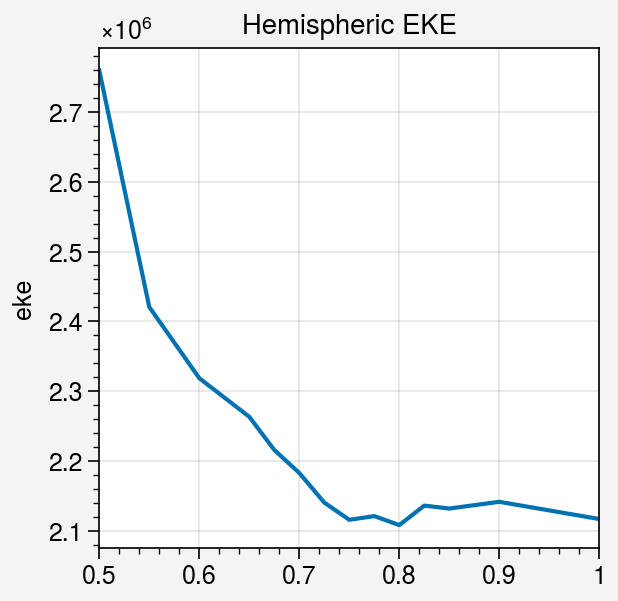

In [53]:
fgs = np.array([get_fgamma_from(en) for en in exp_names])
ds = ds_zm.sel(plev=slice(50,1000)).mean('time').groupby(np.abs(ds_zm.lat)).mean()
hem_eke = ds.eke.weighted(full_weights).sum(['plev','lat'])

fig, ax = pplt.subplots(title='Hemispheric EKE')

ax.plot(fgs, hem_eke)

fig.savefig(f'Intercomparison_hem_eke.{plot_format}')

In [33]:
df_diagn = setup_diagnostic_dataframe(exp_names)

EMIL_SW90_f070 already in index
EMIL_SW90_f080 already in index


In [13]:
ds_diagn = xr.Dataset.from_dataframe(df_diagn)
df_diagn

Ty_actual     Ty_eff  Ty_equ    edj_lat    edj_max  \
exp_name       hemisphere                                                       
EMIL_SW90_f050 NH          37.885824  90.232679      90  47.439944   5.319676   
               SH          38.031697  90.232679      90  46.044721   6.576468   
EMIL_SW90_f055 NH          37.071089  90.232679      90  50.230478   6.972635   
               SH          37.312731  90.232679      90  49.765404   7.814119   
EMIL_SW90_f060 NH          37.267265  90.232679      90  49.765401   8.646901   
               SH          37.139622  90.232679      90  49.765401   8.606471   
EMIL_SW90_f065 NH          37.424347  90.232679      90  48.835236   9.472293   
               SH          38.363768  90.232679      90  47.905069   9.943561   
EMIL_SW90_f067 NH          37.772746  90.232679      90  46.509813  10.122219   
               SH          37.145171  90.232679      90  47.905069   9.918398   
EMIL_SW90_f070 NH          36.635183  90.232679      90  45.579639  10.192267   
               SH          37.708621  90.232679      90  46.044724  10.296381   
EMIL_SW90_f072 NH          36.983766  90.232679      90  44.184373  10.822990   
               SH          37.254867  90.232679      90  45.579639  10.762449   
EMIL_SW90_f075 NH          36.580995  90.232679      90  42.324011  10.105296   
               SH          36.200791  90.232679      90  44.184373  10.734316   
EMIL_SW90_f077 NH          35.352717  90.232679      90  39.533463   9.748319   
               SH          36.044476  90.232679      90  40.463642   9.726487   
EMIL_SW90_f080 NH          35.627408  90.232679      90  39.533463  10.123677   
               SH          35.558814  90.232679      90  37.673087   9.349949   
EMIL_SW90_f082 NH          36.359253  90.232679      90  35.812711   9.423215   
               SH          35.736382  90.232679      90  35.812709   8.552487   
EMIL_SW90_f085 NH          36.359070  90.232679      90  34.882521   9.699236   
               SH          36.681719  90.232679      90  33.952327   8.368544   
EMIL_SW90_f090 NH          37.847928  90.232679      90  30.696652   8.359458   
               SH          37.281586  90.232679      90  31.626846   8.869662   
EMIL_SW90_f100 NH          39.738145  90.232679      90  28.836260   7.643563   
               SH          39.906232  90.232679      90  28.836261   8.045482   

                           lat_0  lat_0_actual    stj_lat    stj_max  \
exp_name       hemisphere                                              
EMIL_SW90_f050 NH              0          0.11  32.557042  57.775007   
               SH              0          0.11  33.952330  56.216153   
EMIL_SW90_f055 NH              0          0.22  32.091946  49.677052   
               SH              0          0.22  32.557042  46.861575   
EMIL_SW90_f060 NH              0         -0.15  32.091946  41.184814   
               SH              0         -0.15  32.091946  41.271061   
EMIL_SW90_f065 NH              0         -0.23  31.161750  37.640521   
               SH              0         -0.23  31.161750  38.322020   
EMIL_SW90_f067 NH              0         -0.02  30.696651  33.271720   
               SH              0         -0.02  30.231554  33.532376   
EMIL_SW90_f070 NH              0          0.15  30.231554  30.865841   
               SH              0          0.15  28.836261  30.447953   
EMIL_SW90_f072 NH              0         -0.09  29.766450  26.237210   
               SH              0         -0.09  27.906063  24.951335   
EMIL_SW90_f075 NH              0         -0.12  34.882507  30.993443   
               SH              0         -0.12  34.882507  29.648428   
EMIL_SW90_f077 NH              0         -0.39  38.138180  34.026636   
               SH              0         -0.39  32.091933  27.641164   
EMIL_SW90_f080 NH              0          0.09  37.673088  32.498295   
               SH              0          0.09  34.417414  31.007382   
EMIL_SW90_f0

## Visualization

In [14]:
ds_diagn.sel(exp_name=exp_names).to_dataframe()

Ty_actual     Ty_eff  Ty_equ    edj_lat    edj_max  \
exp_name       hemisphere                                                       
EMIL_SW90_f070 NH          36.635183  90.232679      90  45.579639  10.192267   
               SH          37.708621  90.232679      90  46.044724  10.296381   
EMIL_SW90_f080 NH          35.627408  90.232679      90  39.533463  10.123677   
               SH          35.558814  90.232679      90  37.673087   9.349949   

                           lat_0  lat_0_actual    stj_lat    stj_max  \
exp_name       hemisphere                                              
EMIL_SW90_f070 NH              0          0.15  30.231554  30.865841   
               SH              0          0.15  28.836261  30.447953   
EMIL_SW90_f080 NH              0          0.09  37.673088  32.498295   
               SH              0          0.09  34.417414  31.007382   

                             stj_plev  vuet_lat_max      vuet_max  \
exp_name       hemisphere                                           
EMIL_SW90_f070 NH          168.923004     34.882523  20992.804026   
               SH          168.923004     34.882523  21299.585699   
EMIL_SW90_f080 NH          228.672729     29.301359  19229.063267   
               SH          228.672729     29.301359  19814.784648   

                             vuet_total      jet_corr  f_gamma  T_coldpoint  \
exp_name       hemisphere                                                     
EMIL_SW90_f070 NH          7.038123e+19 -3.999999e-01      0.7   184.455322   
               SH          6.633800e+19 -8.824072e-07      0.7   184.455322   
EMIL_SW90_f080 NH          5.302124e+19           NaN      0.8   178.486954   
               SH          5.231267e+19 -6.517511e-01      0.8   178.486954   

                                Psi_max      Psi_0  
exp_name       hemisphere                           
EMIL_SW90_f070 NH          5.932517e+10  31.225693  
               SH         -5.892794e+10  31.336618  
EMIL_SW90_f080 NH          9.120421e+10  27.136776  
               SH         -8.797413e+10  27.522800

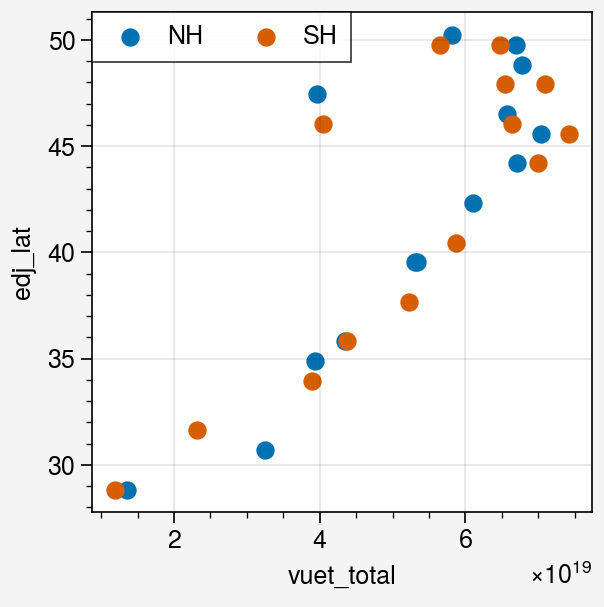

In [44]:
met1 = 'vuet_total'
met2 = 'edj_lat'

ds = ds_diagn.sel(exp_name=exp_names)

fig, ax = pplt.subplots()

ax.scatter(ds[met1], ds[met2])
ax.legend()

fig.savefig(f'Intercomparison_scatterplot_{met1}_{met2}.{plot_format}')

In [ ]:
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe().reset_index(), vars=['Ty_actual', 'edj_lat', 'edj_max'], hue='hemisphere', diag_kind='hist')
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe(), vars=['Ty_actual', 'edj_lat', 'edj_max'])
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe(), vars=['Ty_actual', 'stj_lat', 'stj_max', 'stj_plev'])
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe())

ds = ds_diagn.sel(exp_name=exp_names)
metrics = list(ds_diagn.keys())
comp_metric = 'f_gamma'

fig, axes = pplt.subplots(nrows=len(metrics), share=False)

for i,met in enumerate(metrics):
    
    axes[i].scatter(ds[met], ds[comp_metric])
    
for ax in axes:
    ax.legend()
    
fig.savefig(f'Intercomparison_scatterplots.{plot_format}')

In [9]:
plt.show()

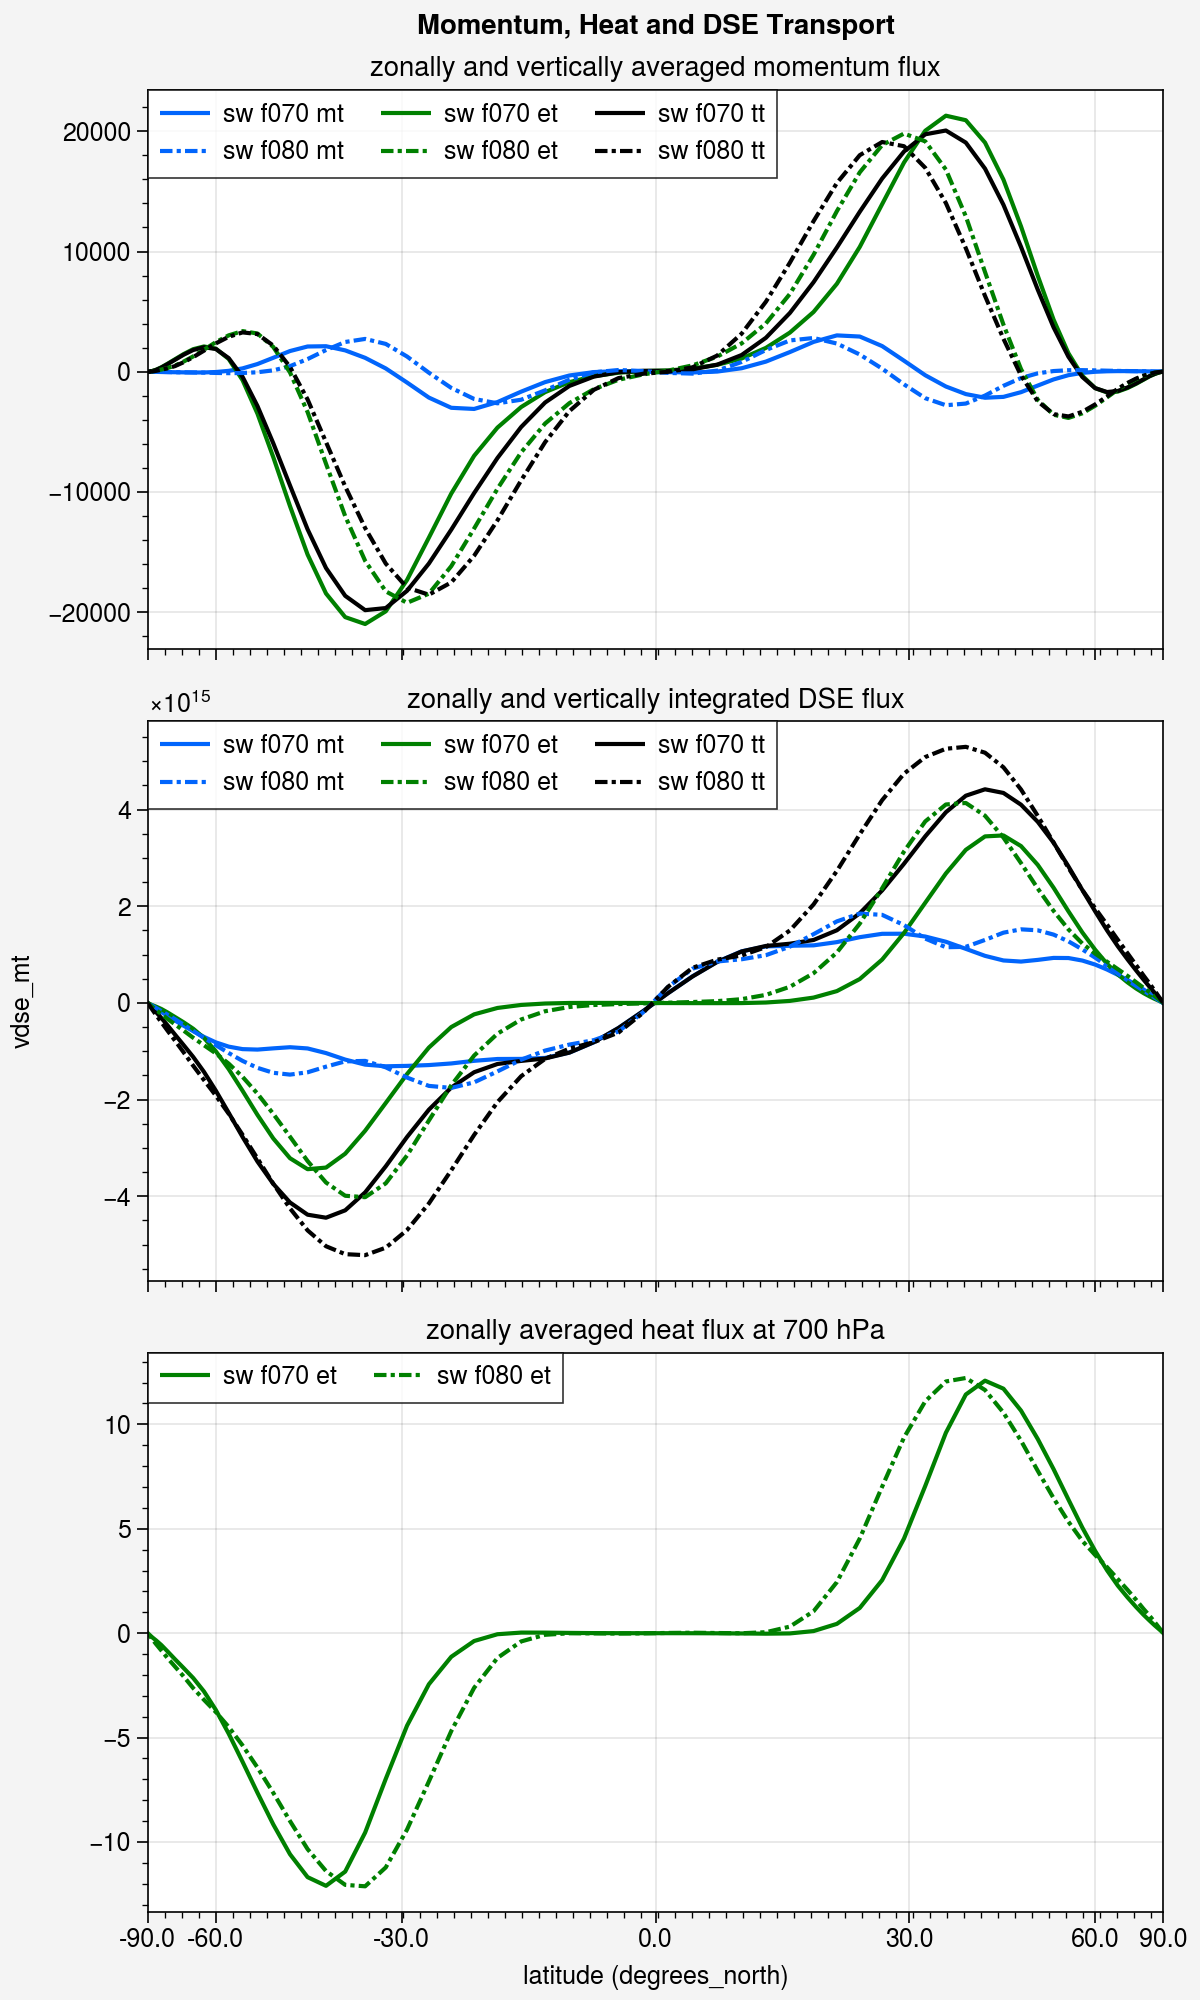

In [23]:
fig, ax = pplt.subplots(nrows = 3, ncols = 1, figsize = (6, 10), figtitle='Momentum, Heat and DSE Transport')


for i,en in enumerate(exp_names):
    fig, ax = plot_transports_intercomp(ds_tp.sel(exp_name=en), vert_weights, 
                                        fig=fig, ax=ax, linestyle=linestyles[i],
                                       )
fig.show()
fig.savefig(f'Intercomparison_fluxes.{plot_format}')

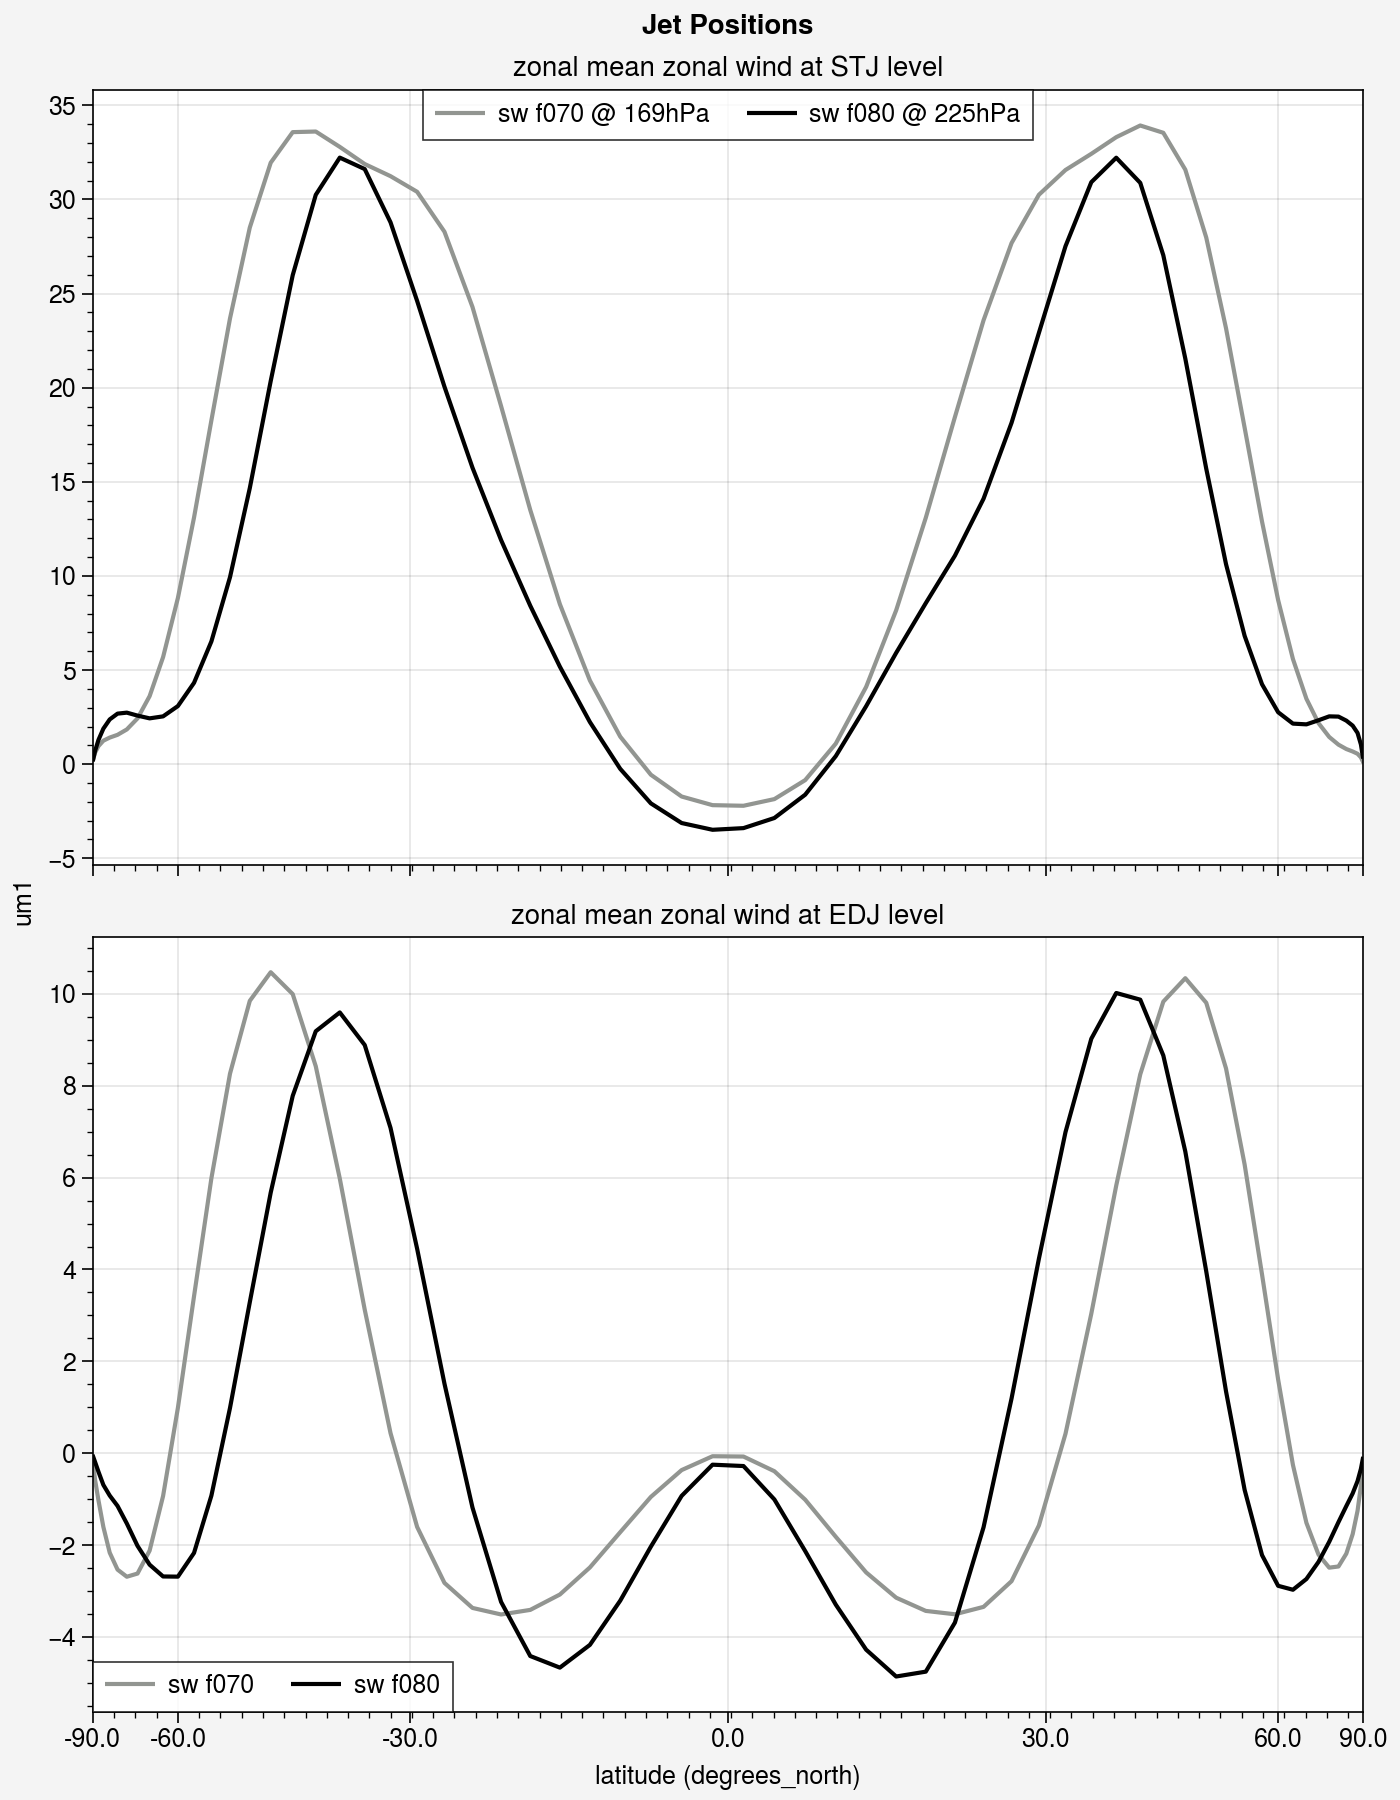

In [16]:
fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Jet Positions')

for i,en in enumerate(exp_names):
    fig, ax = plot_u_jets_intercomp(ds_zm.sel(exp_name=en), 
                                        fig=fig, ax=ax, linestyle=linestyles[int(i/2)], color=alternation_colors[i%2]
                                       )
fig.show()
fig.savefig(f'Intercomparison_jets.{plot_format}')

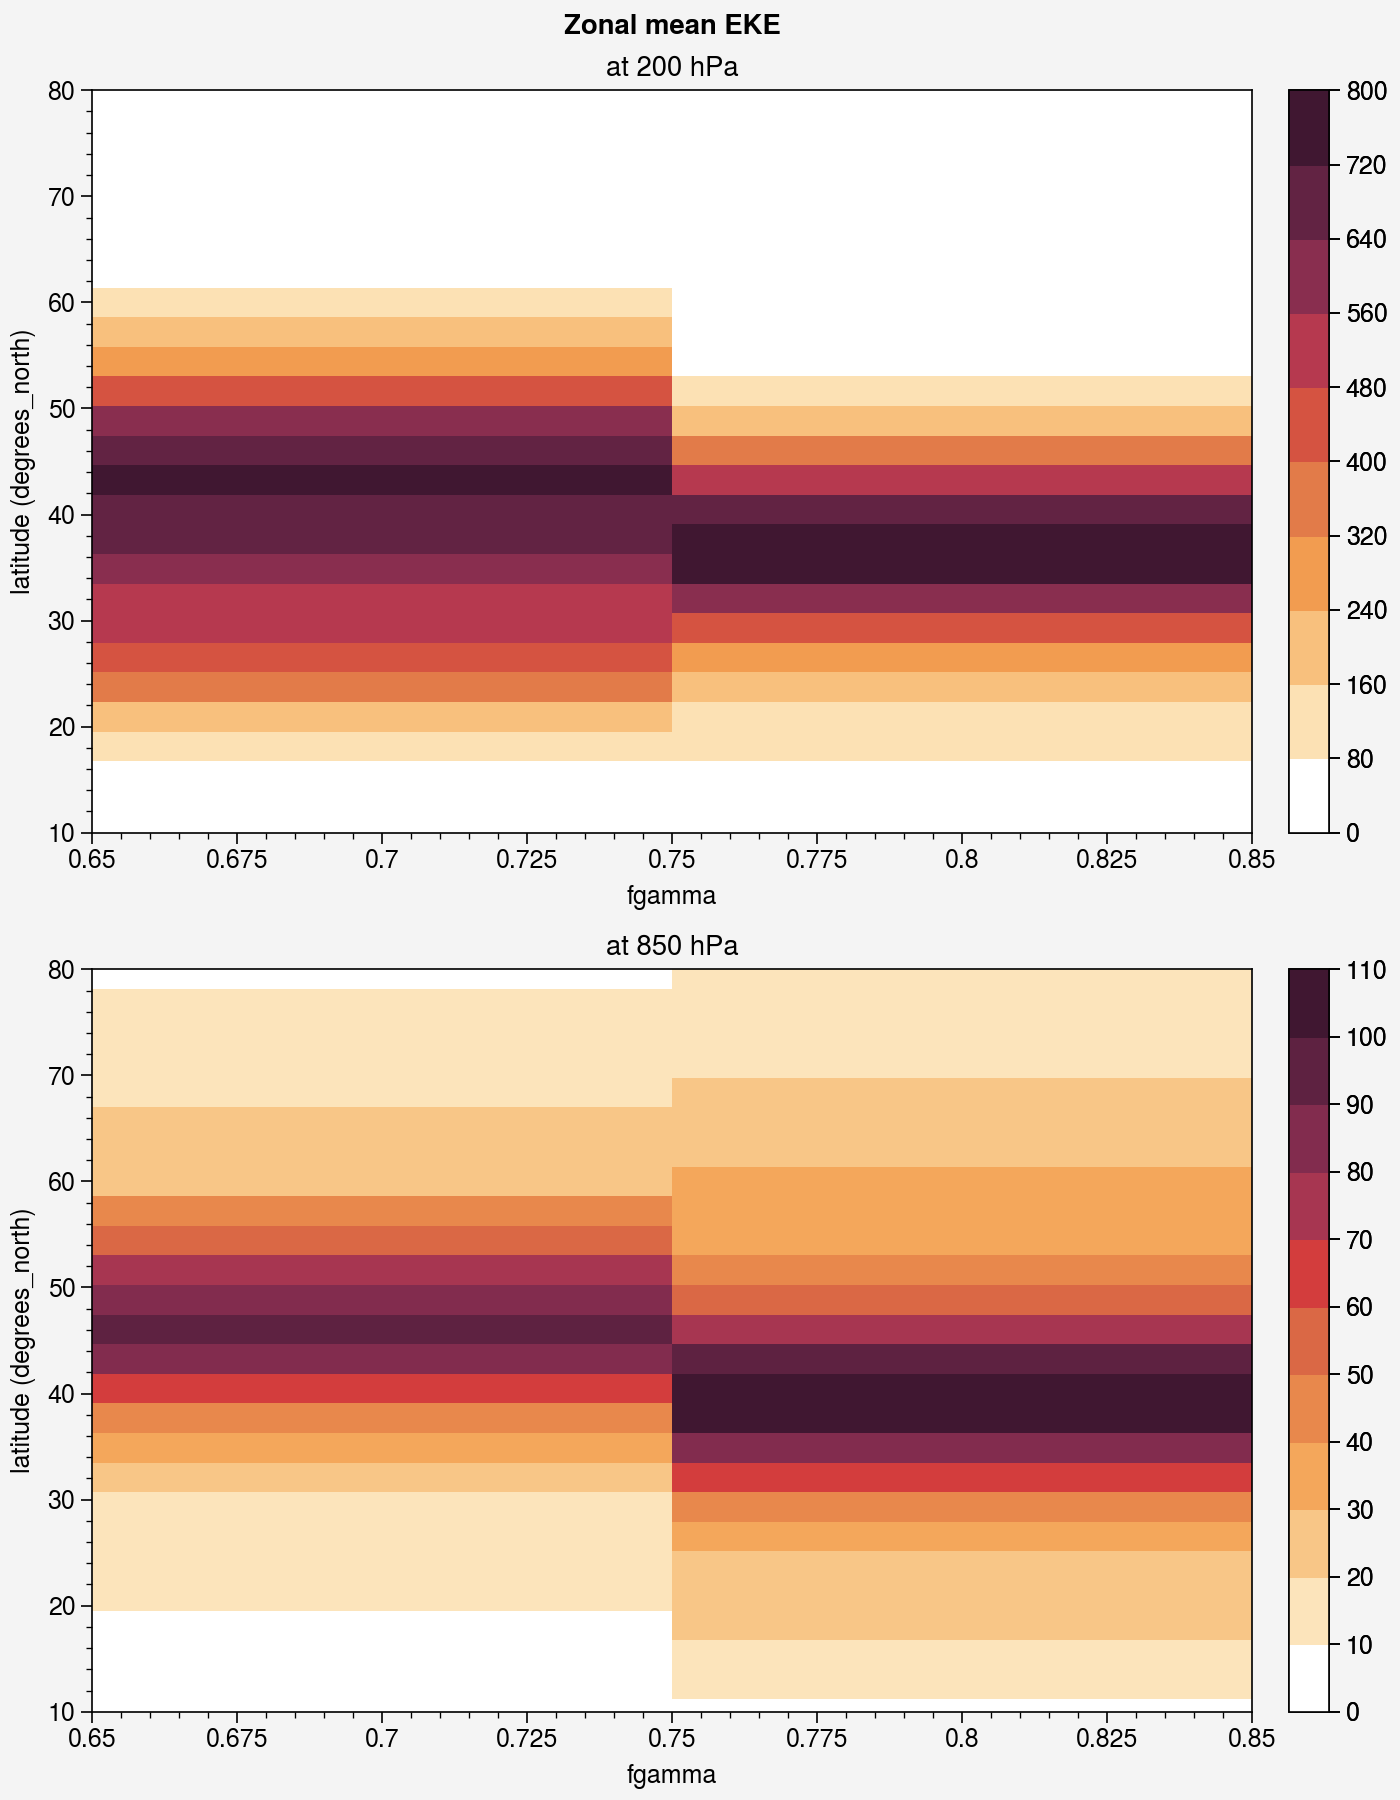

In [17]:
fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Zonal mean EKE', share=False)

fig, ax = plot_eke_contours_intercomp(ds_zm, exp_names, fig=fig, ax=ax)

fig.savefig(f'Intercomparison_eke_colormesh.{plot_format}')

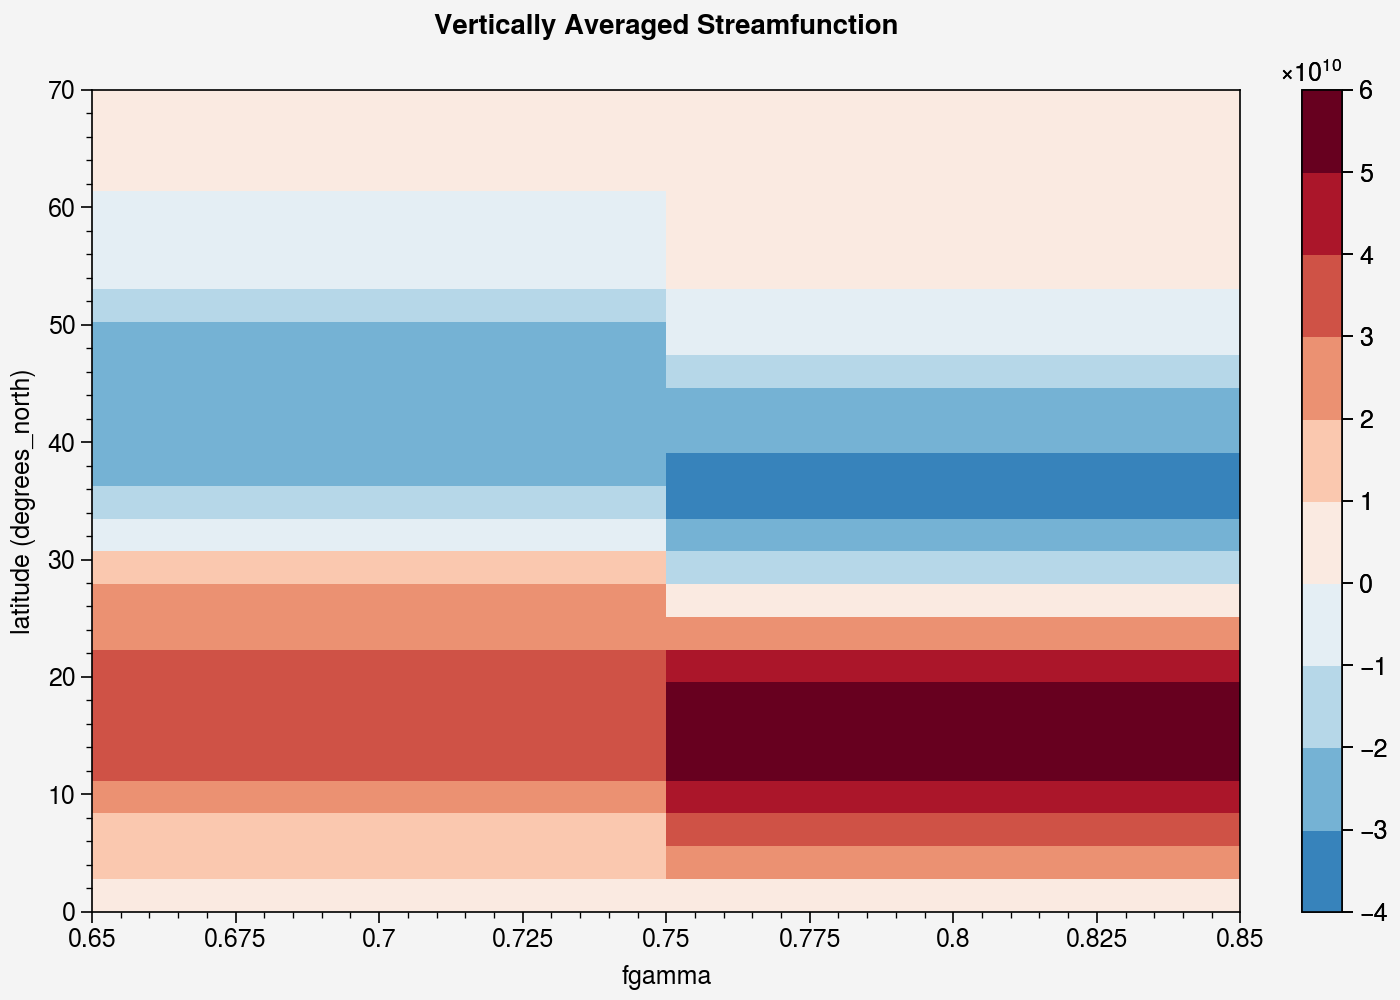

In [18]:
fig, ax = pplt.subplots(nrows = 1, ncols = 1, figsize = (7, 5), figtitle='Vertically Averaged Streamfunction')

fig, ax = plot_psi_contours_intercomp(ds_zm, exp_names, vert_weights, fig=fig, ax=ax)

fig.savefig(f'Intercomparison_psi_colormesh.{plot_format}')

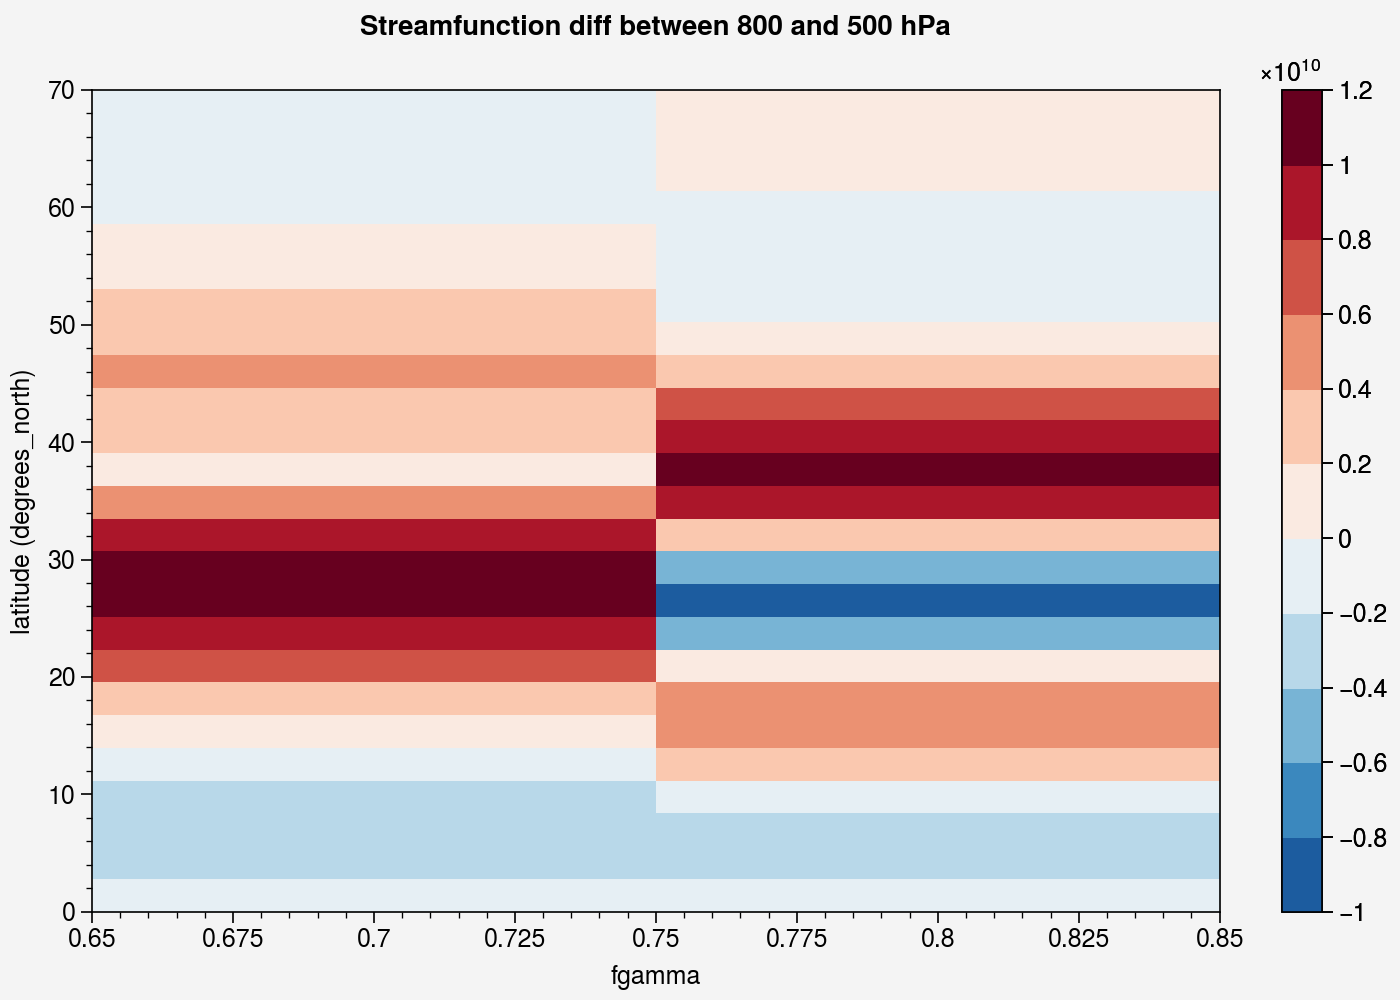

In [19]:
# Idee

def plot_psi_baroclinicity_contours_intercomp(ds_zm, exp_names, fig=None, ax=None):
    
    if fig is None:
        fig, ax = pplt.subplots(nrows = 1, ncols = 1, figsize = (7, 5), figtitle='Streamfunction diff between 800 and 500 hPa')

    lats = ds_zm.sel(lat = slice(90,0)).lat
    fgs = np.array([get_fgamma_from(en) for en in exp_names])

    psi_bc = ds_zm.psi.sel(lat = slice(90,0)).interp(plev=800) - ds_zm.psi.sel(lat = slice(90,0)).interp(plev=500)
    
    ax.pcolormesh(fgs, lats, psi_bc.values.T, colorbar='right')

    for a in ax:
        a.set_xlabel('fgamma')
        a.set_ylim([0, 70])
    
    return fig, ax 

fig, ax = plot_psi_baroclinicity_contours_intercomp(ds_zm, exp_names)

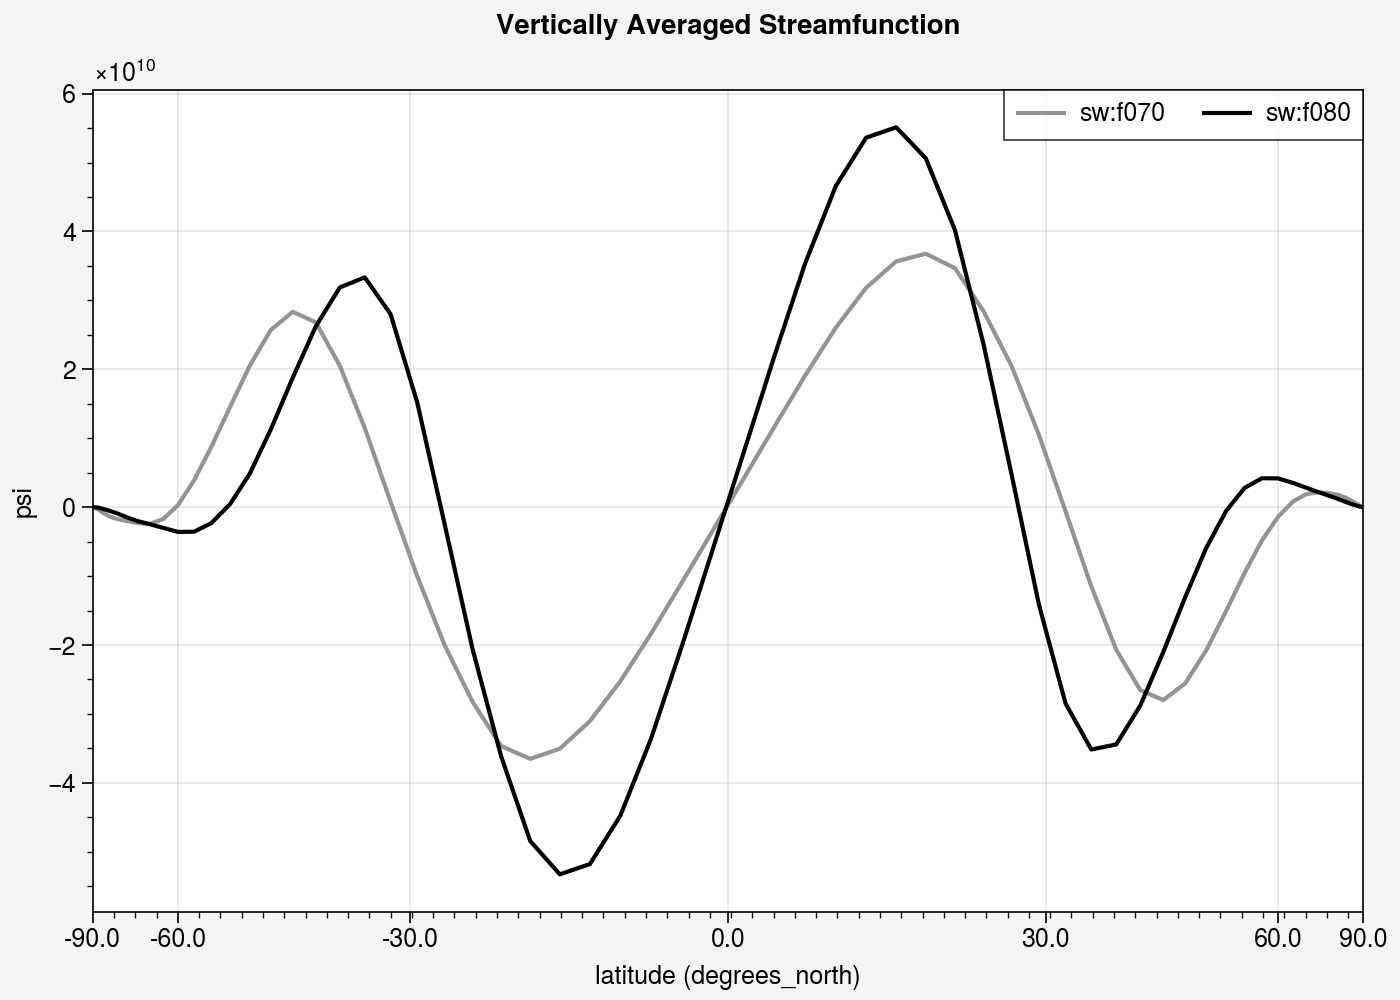

In [20]:
fig, ax = pplt.subplots(nrows = 1, ncols = 1, figsize = (7, 5), figtitle='Vertically Averaged Streamfunction')

for i,en in enumerate(exp_names):
    fig, ax = plot_psi_intercomp(ds_zm.sel(exp_name=en).mean('time'), vert_weights,
                                 fig=fig, ax=ax, linestyle=linestyles[int(i/2)], color=alternation_colors[i%2])

fig.show()
fig.savefig(f'Intercomparison_streamfunction.{plot_format}')

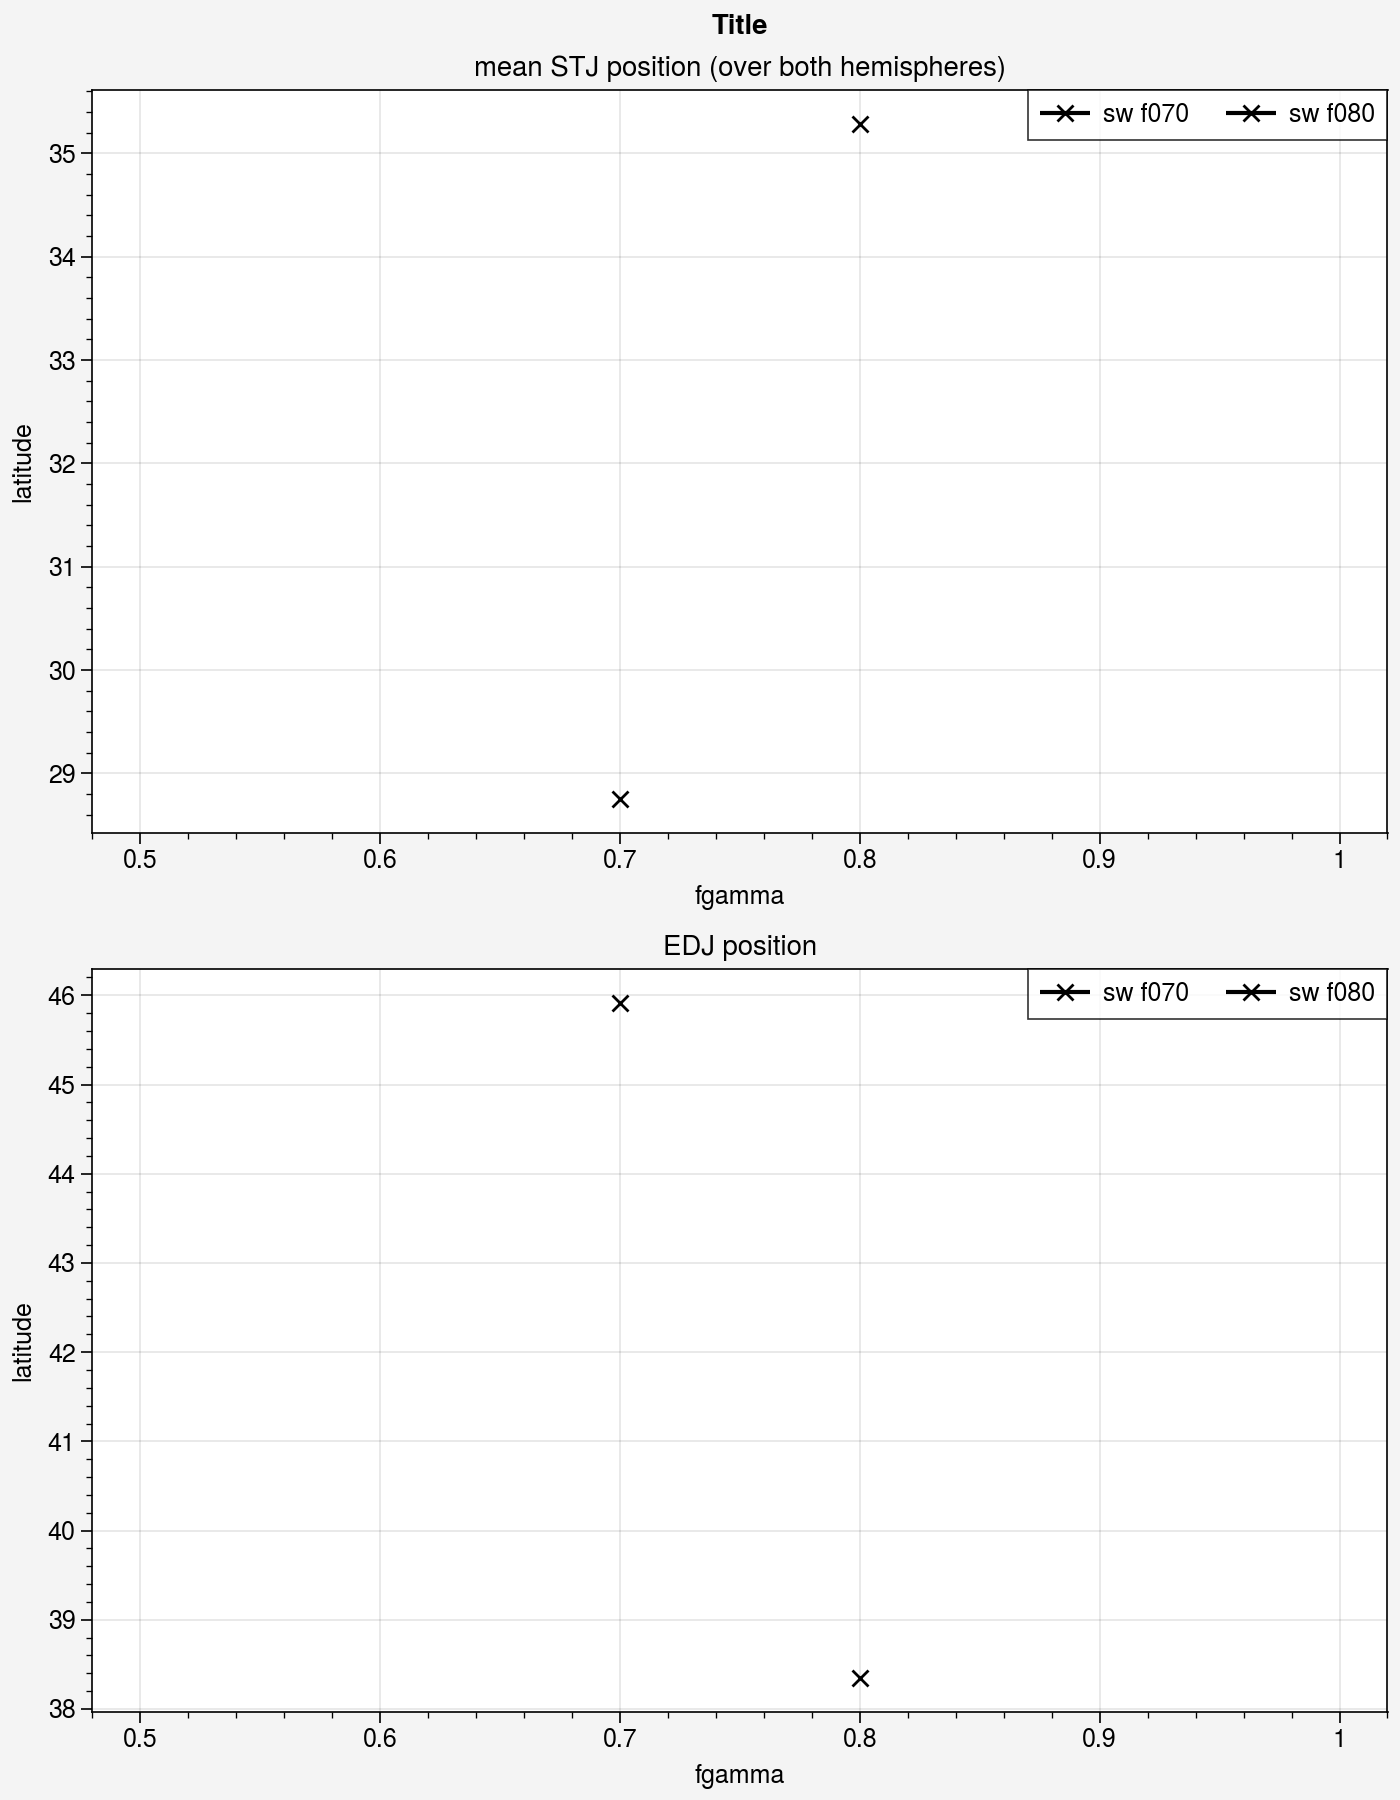

In [21]:
fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Title', share=False)

colors = ['black', 'bright green', 'bright blue', 'purple', 'orange']

for i,en in enumerate(exp_names):
    fig, ax = plot_jet_metrics(ds_zm.sel(exp_name=en), 
                                        fig=fig, ax=ax, color=colors[0],
                                       )

#ax[0].legend(loc='upper left')
#ax[1].legend()
    
for a in ax:
    a.set_xlim([0.48, 1.02])

fig.show()
fig.savefig(f'Intercomparison_jet_lats_metric.{plot_format}')

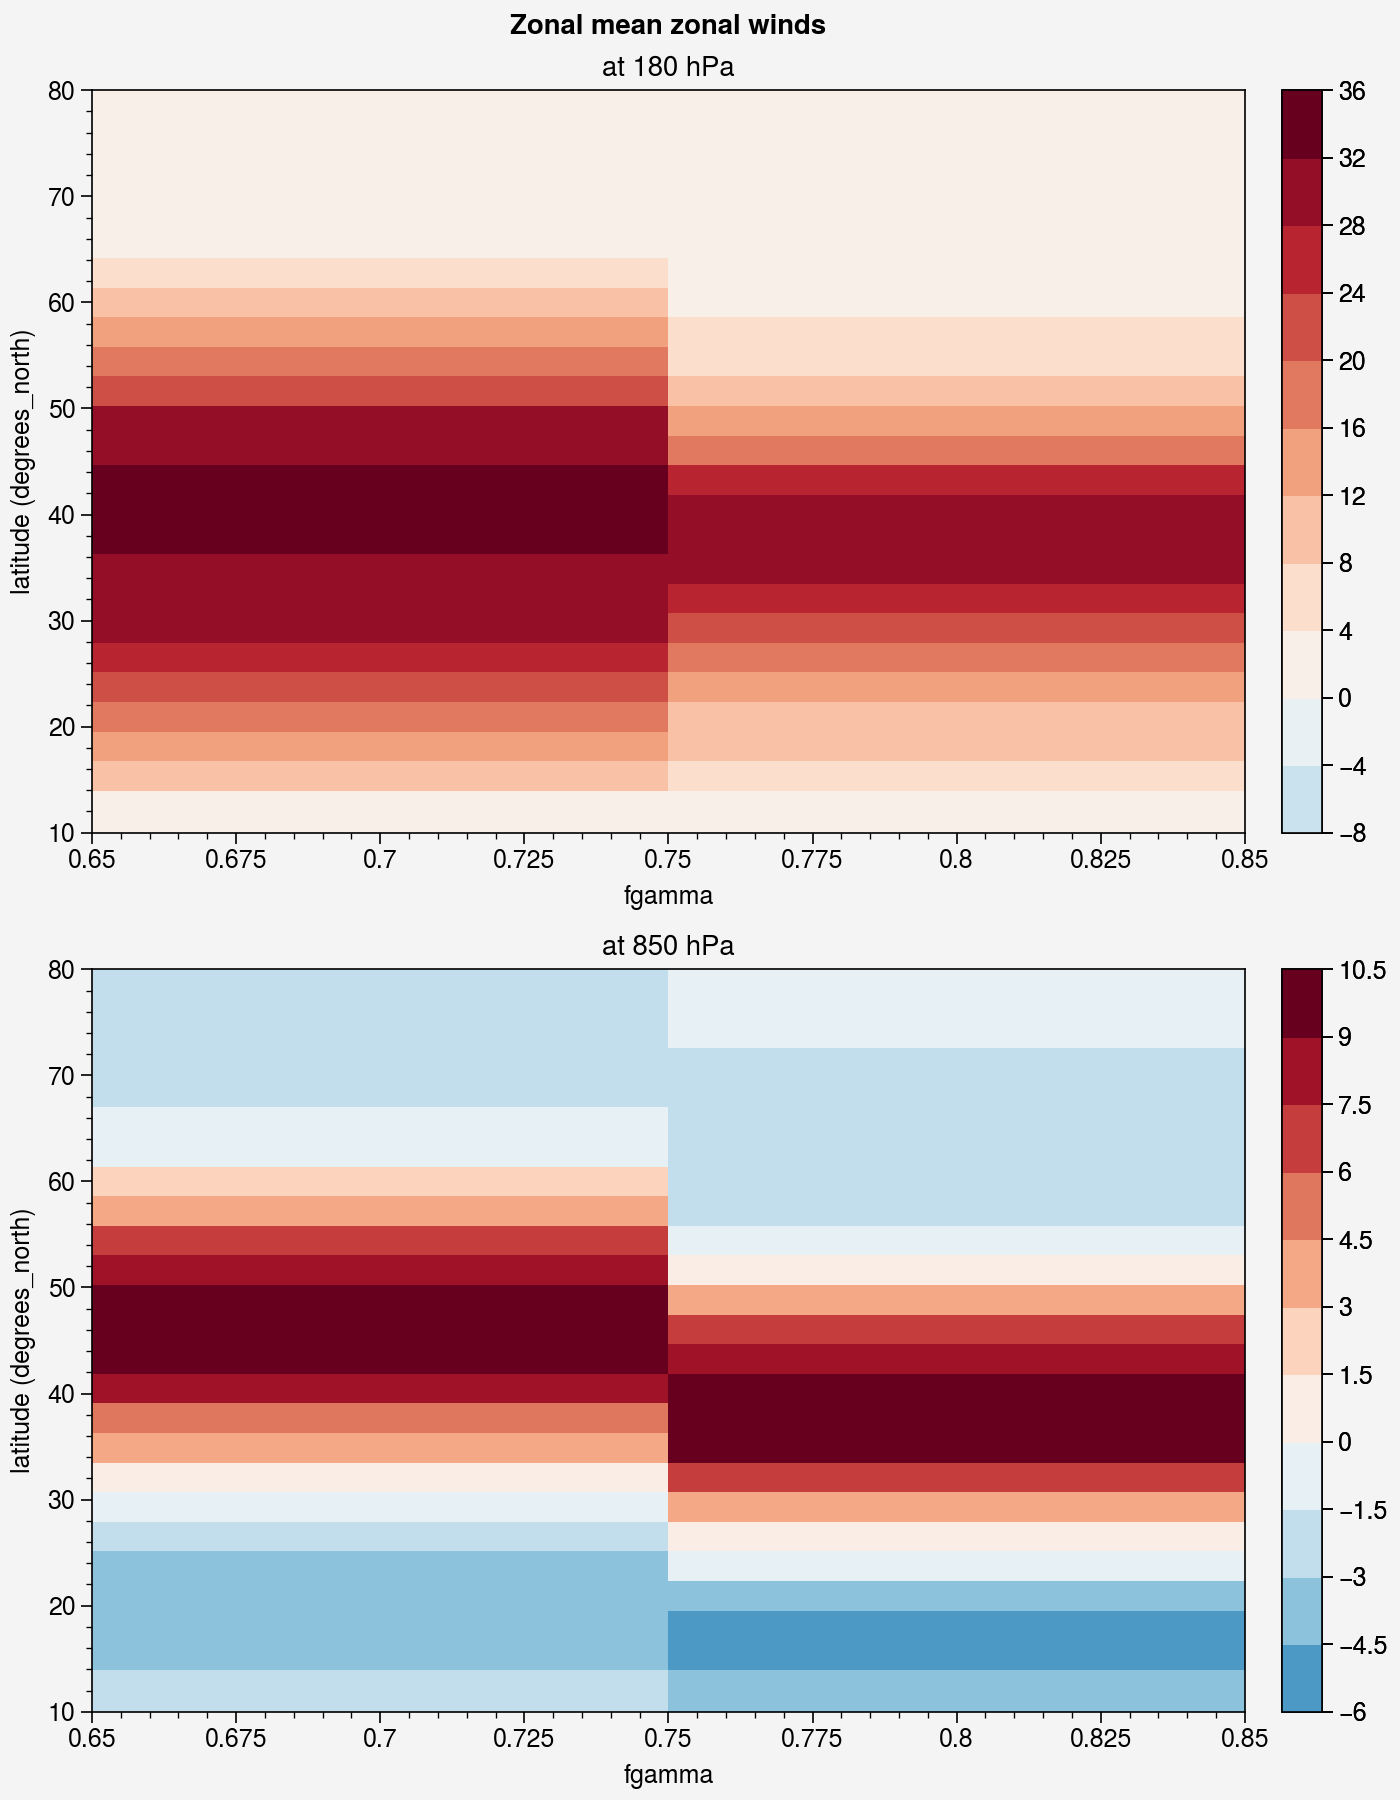

In [22]:
fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Zonal mean zonal winds', share=False)

fig, ax = plot_jet_contours_intercomp(ds_zm, exp_names, fig=fig, ax=ax)

fig.savefig(f'Intercomparison_jet_colormesh.{plot_format}')

## Calculation of Diagnostics

### Parameters

In [46]:
for exp_name in exp_names:
    df_diagn.loc[(exp_name,),'f_gamma'] = get_fgamma_from(exp_name)


### EDJ and STJ related

In [47]:
j = 0
#fig, ax = pplt.subplots(nrows=len(exp_names))
for exp_name in exp_names:
    ds = ds_zm.sel(exp_name=exp_name).resample(time='1M').mean('time')
    ds = ds.sel(time=ds.time[::2])    
    
    nt = ds.time.size
    edj_lats = np.zeros((nt,2))
    stj_lats = np.zeros((nt,2))
    
    edj_plevs = np.zeros(nt)
    stj_plevs = np.zeros(nt)

    for i in range(nt):
        edj_lats[i], stj_lats[i], edj_plevs[i], stj_plevs[i] = calc_jet_lats(ds.isel(time=i))
    
    edj_lat = np.mean(edj_lats, axis = 0)
    stj_lat = np.mean(stj_lats, axis = 0)
    edj_plev = np.mean(edj_plevs)
    stj_plev = np.mean(stj_plevs)
    
    #ax[j].scatter(edj_lats, stj_lats)
    j += 1
    jet_corr_nh = np.corrcoef(stj_lats[:,0], edj_lats[:,0])[0,1]
    jet_corr_sh = np.corrcoef(stj_lats[:,1], edj_lats[:,1])[0,1]
    df_diagn.loc[(exp_name, 'NH'),'jet_corr'] = jet_corr_nh
    df_diagn.loc[(exp_name, 'SH'),'jet_corr'] = jet_corr_sh
    # absolute values so the scatterplots are more informative
    df_diagn.loc[(exp_name,),'edj_lat'] = np.abs(edj_lat)
    df_diagn.loc[(exp_name,),'stj_lat'] = np.abs(stj_lat)

    df_diagn.loc[(exp_name,'NH'),'stj_max'] = ds.um1.sel(plev=stj_plev, method='nearest').mean(['time']).interp(lat=stj_lat[0]).values
    df_diagn.loc[(exp_name,'SH'),'stj_max'] = ds.um1.sel(plev=stj_plev, method='nearest').mean(['time']).interp(lat=stj_lat[1]).values
    df_diagn.loc[(exp_name,'NH'),'edj_max'] = ds.um1.sel(plev=edj_plev, method='nearest').mean(['time']).interp(lat=edj_lat[0]).values
    df_diagn.loc[(exp_name,'SH'),'edj_max'] = ds.um1.sel(plev=edj_plev, method='nearest').mean(['time']).interp(lat=edj_lat[1]).values
    df_diagn.loc[(exp_name,),'stj_plev'] = stj_plev

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/sw/s

### Hadley Cell

In [48]:
for exp_name in exp_names:
    ds = ds_zm.sel(exp_name=exp_name)
    da_psi = ds.psi
    
    df_diagn.loc[(exp_name,'NH'),'Psi_max'] = da_psi.sel(lat=slice(90,0)).max().values
    df_diagn.loc[(exp_name,'SH'),'Psi_max'] = da_psi.sel(lat=slice(0,-90)).min().values
    
    df_diagn.loc[(exp_name,),'Psi_0'] = np.abs(tropdm.TropD_Metric_PSI(ds.vm1.mean('time').values.T, ds.lat.values, ds.plev.values))


In [49]:
df_diagn

Ty_actual     Ty_eff Ty_equ    edj_lat  \
exp_name       hemisphere                                           
EMIL_SW90_f050 NH          37.885824  50.129264     50  47.439944   
               SH          38.031697  50.129264     50  46.044721   
EMIL_SW90_f055 NH          37.071089  90.232679     90  50.230478   
               SH          37.312731  90.232679     90  49.765404   
EMIL_SW90_f060 NH          37.267265  90.232679     90  49.765401   
               SH          37.139622  90.232679     90  49.765401   
EMIL_SW90_f065 NH          37.424347  90.232679     90  48.835236   
               SH          38.363768  90.232679     90  47.905069   
EMIL_SW90_f067 NH          37.772746  90.232679     90  46.509813   
               SH          37.145171  90.232679     90  47.905069   
EMIL_SW90_f070 NH          36.635183  90.232679     90  45.579639   
               SH          37.708621  90.232679     90  46.044724   
EMIL_SW90_f072 NH          36.983766  90.232679     90  44.184373   
               SH          37.254867  90.232679     90  45.579639   
EMIL_SW90_f075 NH          36.580995  90.232679     90  42.324011   
               SH          36.200791  90.232679     90  44.184373   
EMIL_SW90_f077 NH          35.352717  90.232679     90  39.533463   
               SH          36.044476  90.232679     90  40.463642   
EMIL_SW90_f080 NH          35.627408  90.232679     90  39.533463   
               SH          35.558814  90.232679     90  37.673087   
EMIL_SW90_f082 NH          36.359253  90.232679     90  35.812711   
               SH          35.736382  90.232679     90  35.812709   
EMIL_SW90_f085 NH           36.35907  90.232679     90  34.882521   
               SH          36.681719  90.232679     90  33.952327   
EMIL_SW90_f090 NH          37.847928  90.232679     90  30.696652   
               SH          37.281586  90.232679     90  31.626846   
EMIL_SW90_f100 NH          39.738145  90.232679     90   28.83626   
               SH          39.906232  90.232679     90  28.836261   

                                      edj_max lat_0 lat_0_actual    stj_lat  \
exp_name       hemisphere                                                     
EMIL_SW90_f050 NH          5.3196762868834355     0         0.11  32.557042   
               SH           6.576468040318844     0         0.11   33.95233   
EMIL_SW90_f055 NH           6.972635037321197     0         0.22  32.091946   
               SH          7.8141191783919055     0         0.22  32.557042   
EMIL_SW90_f060 NH           8.646900792557332     0        -0.15  32.091946   
               SH           8.606471294793304     0        -0.15  32.091946   
EMIL_SW90_f065 NH           9.472293434898726     0        -0.23   31.16175   
               SH           9.943560920194537     0        -0.23   31.16175   
EMIL_SW90_f067 NH          10.122218608008685     0        -0.02  30.696651   
               SH           9.918397904176269     0        -0.02  30.231554   
EMIL_SW90_f070 NH          10.192266632783099     0         0.15  30.231554   
               SH          10.296381338284409     0         0.15  28.836261   
EMIL_SW90_f072 NH            10.8229904146975     0        -0.09   29.76645   
               SH          10.762449263181216     0        -0.09  27.906063   
EMIL_SW90_f075 NH           10.10529605497815     0        -0.12  34.882507   
               SH          10.734315543305266     0        -0.12  34.882507   
EMIL_SW90_f077 NH           9.748318670334896     0        -0.39   38.13818   
               SH           9.726487336452237     0        -0.39  32.091933   
EMIL_SW90_f080 NH          10.123676618780195     0         0.09  37.673088   
               SH            9.34994875670074     0         0.09  34.417414   
EMIL_SW90_f082 NH             9.4232149138332     0        -0.12  36.277805   
               SH           8.552486713352247     0        -0.12  34.882519   
EMIL_SW90_f085 NH           9.699236346396276     0         

### Meridional temperature gradients & cold point

In [50]:
for exp_name in exp_names:
    ds = ds_zm.sel(exp_name=exp_name)
    ty = get_ty_from(exp_name)
    setup = get_setup_from(exp_name)
    l0 = get_l0_from(exp_name)

    da_sfct = ds.tm1.sel(lat=slice(10,-10)).mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"})
    l0_act = np.round(tropdf.TropD_Calculate_MaxLat(da_sfct.values, da_sfct.lat.values), decimals=2)
    
    ## Calculation of hemispheric temperature difference on NH
    df_diagn.loc[(exp_name,'NH'),'Ty_actual'] = (
        ds.tm1.mean('time').dropna('plev').interp(lat=l0_act, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}).values - 
        ds.tm1.mean('time').dropna('plev').interp(lat=90, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}).values
    )

    ## Calculation of hemispheric temperature difference on SH
    df_diagn.loc[(exp_name,'SH'),'Ty_actual'] = (
        ds.tm1.mean('time').dropna('plev').interp(lat=l0_act, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}).values - 
        ds.tm1.mean('time').dropna('plev').interp(lat=-90, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}).values
    )

    ## Calculation of hemispheric temperature difference from T_equ
    df_diagn.loc[(exp_name,),'Ty_eff'] = calc_Ty_eff(setup, ty, l0, ds.lat)[:2]
    t_equ_sfc = calc_Ty_eff(setup, ty, l0, ds.lat)[2]

    ## Calculation of the latitudes of the surface temperature maxima in T_equ and the actual T_sfc  
    df_diagn.loc[(exp_name,),'lat_0'] = l0
    df_diagn.loc[(exp_name,),'lat_0_actual'] = float(l0_act)

    ## Saving the nominal temperature difference 
    df_diagn.loc[(exp_name,),'Ty_equ'] = ty
    
    ## Cold point temperature is not a hemispheric metric. Same value stored in both
    df_diagn.loc[(exp_name,),'T_coldpoint'] = ds.tm1.mean('time').min()



In [51]:
df_diagn

Ty_actual     Ty_eff Ty_equ    edj_lat  \
exp_name       hemisphere                                           
EMIL_SW90_f050 NH          37.885824  90.232679     90  47.439944   
               SH          38.031697  90.232679     90  46.044721   
EMIL_SW90_f055 NH          37.071089  90.232679     90  50.230478   
               SH          37.312731  90.232679     90  49.765404   
EMIL_SW90_f060 NH          37.267265  90.232679     90  49.765401   
               SH          37.139622  90.232679     90  49.765401   
EMIL_SW90_f065 NH          37.424347  90.232679     90  48.835236   
               SH          38.363768  90.232679     90  47.905069   
EMIL_SW90_f067 NH          37.772746  90.232679     90  46.509813   
               SH          37.145171  90.232679     90  47.905069   
EMIL_SW90_f070 NH          36.635183  90.232679     90  45.579639   
               SH          37.708621  90.232679     90  46.044724   
EMIL_SW90_f072 NH          36.983766  90.232679     90  44.184373   
               SH          37.254867  90.232679     90  45.579639   
EMIL_SW90_f075 NH          36.580995  90.232679     90  42.324011   
               SH          36.200791  90.232679     90  44.184373   
EMIL_SW90_f077 NH          35.352717  90.232679     90  39.533463   
               SH          36.044476  90.232679     90  40.463642   
EMIL_SW90_f080 NH          35.627408  90.232679     90  39.533463   
               SH          35.558814  90.232679     90  37.673087   
EMIL_SW90_f082 NH          36.359253  90.232679     90  35.812711   
               SH          35.736382  90.232679     90  35.812709   
EMIL_SW90_f085 NH           36.35907  90.232679     90  34.882521   
               SH          36.681719  90.232679     90  33.952327   
EMIL_SW90_f090 NH          37.847928  90.232679     90  30.696652   
               SH          37.281586  90.232679     90  31.626846   
EMIL_SW90_f100 NH          39.738145  90.232679     90   28.83626   
               SH          39.906232  90.232679     90  28.836261   

                                      edj_max lat_0 lat_0_actual    stj_lat  \
exp_name       hemisphere                                                     
EMIL_SW90_f050 NH          5.3196762868834355     0         0.11  32.557042   
               SH           6.576468040318844     0         0.11   33.95233   
EMIL_SW90_f055 NH           6.972635037321197     0         0.22  32.091946   
               SH          7.8141191783919055     0         0.22  32.557042   
EMIL_SW90_f060 NH           8.646900792557332     0        -0.15  32.091946   
               SH           8.606471294793304     0        -0.15  32.091946   
EMIL_SW90_f065 NH           9.472293434898726     0        -0.23   31.16175   
               SH           9.943560920194537     0        -0.23   31.16175   
EMIL_SW90_f067 NH          10.122218608008685     0        -0.02  30.696651   
               SH           9.918397904176269     0        -0.02  30.231554   
EMIL_SW90_f070 NH          10.192266632783099     0         0.15  30.231554   
               SH          10.296381338284409     0         0.15  28.836261   
EMIL_SW90_f072 NH            10.8229904146975     0        -0.09   29.76645   
               SH          10.762449263181216     0        -0.09  27.906063   
EMIL_SW90_f075 NH           10.10529605497815     0        -0.12  34.882507   
               SH          10.734315543305266     0        -0.12  34.882507   
EMIL_SW90_f077 NH           9.748318670334896     0        -0.39   38.13818   
               SH           9.726487336452237     0        -0.39  32.091933   
EMIL_SW90_f080 NH          10.123676618780195     0         0.09  37.673088   
               SH            9.34994875670074     0         0.09  34.417414   
EMIL_SW90_f082 NH             9.4232149138332     0        -0.12  36.277805   
               SH           8.552486713352247     0        -0.12  34.882519   
EMIL_SW90_f085 NH           9.699236346396276     0         

### Eddy momentum transport related

In [52]:
for exp_name in exp_names:
    ds = ds_tp.vu_et.weighted(weights=vert_weights).mean('plev').sel(exp_name=exp_name)
    #ds_vuet_dg_nh = max_latitude(ds.sel(lat=slice(90,0)))
    #ds_vuet_dg_sh = max_latitude(-ds.sel(lat=slice(0,-90)))
    
    vuet_max_lat_nh = calculate_max_lat(ds.sel(lat=slice(90,0)).mean('time'))
    vuet_max_lat_sh = calculate_max_lat(-ds.sel(lat=slice(0,-90)).mean('time'))
    
    #print(ds_vuet_dg_nh.mean('time'), ds_vuet_dg_sh.mean('time'))
    #print(vuet_max_lat_nh, vuet_max_lat_sh)
    
    df_diagn.loc[(exp_name,'SH'),'vuet_max'] = (ds.sel(lat=slice(90,0)).mean('time')).max('lat').values
    df_diagn.loc[(exp_name,'NH'),'vuet_max'] = (-ds.sel(lat=slice(0,-90)).mean('time')).max('lat').values
    
    df_diagn.loc[(exp_name,),'vuet_lat_max'] = np.abs([vuet_max_lat_nh, vuet_max_lat_sh])

    factor = 0.5*np.pi*r_e * 2*np.pi*r_e
    df_diagn.loc[(exp_name,'NH'),'vuet_total'] = factor * (ds.sel(lat=slice(90,0)).mean('time')).sum('lat').values
    df_diagn.loc[(exp_name,'SH'),'vuet_total'] = factor * (-ds.sel(lat=slice(0,-90)).mean('time')).sum('lat').values

In [53]:
df_diagn.sort_index()

Ty_actual     Ty_eff Ty_equ    edj_lat  \
exp_name       hemisphere                                           
EMIL_SW90_f050 NH          37.885824  90.232679     90  47.439944   
               SH          38.031697  90.232679     90  46.044721   
EMIL_SW90_f055 NH          37.071089  90.232679     90  50.230478   
               SH          37.312731  90.232679     90  49.765404   
EMIL_SW90_f060 NH          37.267265  90.232679     90  49.765401   
               SH          37.139622  90.232679     90  49.765401   
EMIL_SW90_f065 NH          37.424347  90.232679     90  48.835236   
               SH          38.363768  90.232679     90  47.905069   
EMIL_SW90_f067 NH          37.772746  90.232679     90  46.509813   
               SH          37.145171  90.232679     90  47.905069   
EMIL_SW90_f070 NH          36.635183  90.232679     90  45.579639   
               SH          37.708621  90.232679     90  46.044724   
EMIL_SW90_f072 NH          36.983766  90.232679     90  44.184373   
               SH          37.254867  90.232679     90  45.579639   
EMIL_SW90_f075 NH          36.580995  90.232679     90  42.324011   
               SH          36.200791  90.232679     90  44.184373   
EMIL_SW90_f077 NH          35.352717  90.232679     90  39.533463   
               SH          36.044476  90.232679     90  40.463642   
EMIL_SW90_f080 NH          35.627408  90.232679     90  39.533463   
               SH          35.558814  90.232679     90  37.673087   
EMIL_SW90_f082 NH          36.359253  90.232679     90  35.812711   
               SH          35.736382  90.232679     90  35.812709   
EMIL_SW90_f085 NH           36.35907  90.232679     90  34.882521   
               SH          36.681719  90.232679     90  33.952327   
EMIL_SW90_f090 NH          37.847928  90.232679     90  30.696652   
               SH          37.281586  90.232679     90  31.626846   
EMIL_SW90_f100 NH          39.738145  90.232679     90   28.83626   
               SH          39.906232  90.232679     90  28.836261   

                                      edj_max lat_0 lat_0_actual    stj_lat  \
exp_name       hemisphere                                                     
EMIL_SW90_f050 NH          5.3196762868834355     0         0.11  32.557042   
               SH           6.576468040318844     0         0.11   33.95233   
EMIL_SW90_f055 NH           6.972635037321197     0         0.22  32.091946   
               SH          7.8141191783919055     0         0.22  32.557042   
EMIL_SW90_f060 NH           8.646900792557332     0        -0.15  32.091946   
               SH           8.606471294793304     0        -0.15  32.091946   
EMIL_SW90_f065 NH           9.472293434898726     0        -0.23   31.16175   
               SH           9.943560920194537     0        -0.23   31.16175   
EMIL_SW90_f067 NH          10.122218608008685     0        -0.02  30.696651   
               SH           9.918397904176269     0        -0.02  30.231554   
EMIL_SW90_f070 NH          10.192266632783099     0         0.15  30.231554   
               SH          10.296381338284409     0         0.15  28.836261   
EMIL_SW90_f072 NH            10.8229904146975     0        -0.09   29.76645   
               SH          10.762449263181216     0        -0.09  27.906063   
EMIL_SW90_f075 NH           10.10529605497815     0        -0.12  34.882507   
               SH          10.734315543305266     0        -0.12  34.882507   
EMIL_SW90_f077 NH           9.748318670334896     0        -0.39   38.13818   
               SH           9.726487336452237     0        -0.39  32.091933   
EMIL_SW90_f080 NH          10.123676618780195     0         0.09  37.673088   
               SH            9.34994875670074     0         0.09  34.417414   
EMIL_SW90_f082 NH             9.4232149138332     0        -0.12  36.277805   
               SH           8.552486713352247     0        -0.12  34.882519   
EMIL_SW90_f085 NH           9.699236346396276     0         

In [54]:
os.chdir(csv_path)
df_diagn.to_csv('diagnostics.csv')
os.chdir(outpath)

In [16]:
idx = pd.IndexSlice
df_diagn.loc[idx[exp_names,:],:].to_csv('diagnostics.csv')

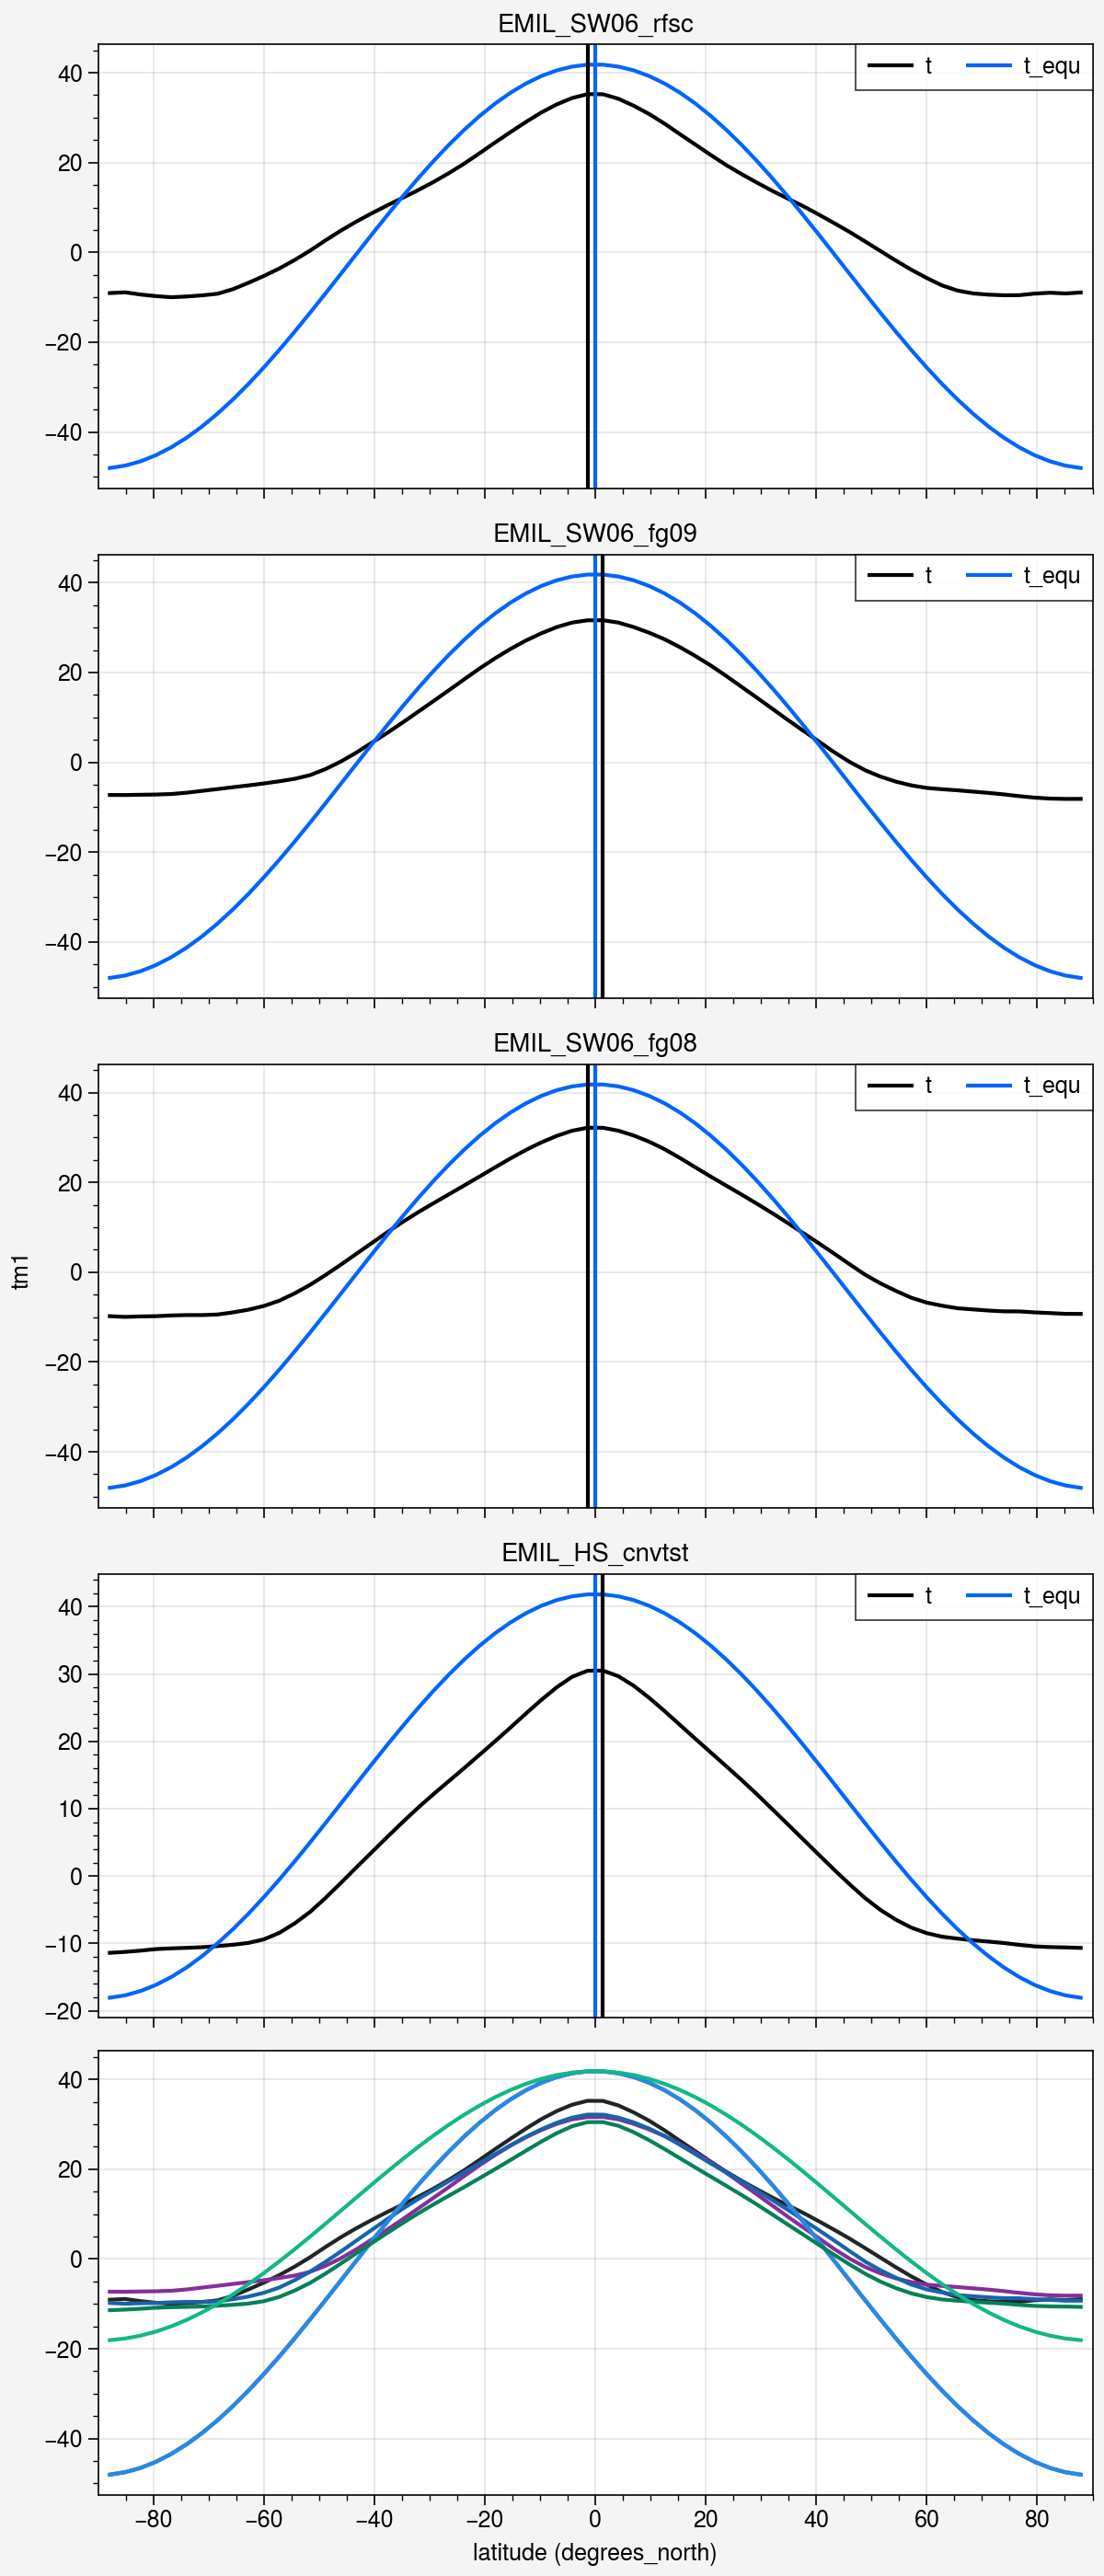

In [8]:
colors=['gray9', 'grape9', 'blue9', 'teal9', 'pink9']
colors_eq=['gray6', 'grape6', 'blue6', 'teal6', 'pink6']

fig, ax = pplt.subplots(figsize=(6,14), nrows=len(exp_names)+1, share=True)

for i, exp_name in enumerate(exp_names):
    ds = ds_zm.sel(exp_name=exp_name)
    ty = get_ty_from(exp_name)
    setup = get_setup_from(exp_name)
    l0 = get_l0_from(exp_name)

    eps= - 12.54
    da_sfct = ds.tm1.mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"})
    l0_act = da_sfct.lat.where(da_sfct == da_sfct.max(), drop=True).values
    
    t_equ_sfc = calc_Ty_eff(setup, ty, l0, ds.lat)[2]
    t_act_sfc = ds.tm1.mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}) - 273.15
    

    ax[-1].plot(ds.lat, t_act_sfc, color=colors[i])
    ax[-1].plot(ds.lat, t_equ_sfc, color=colors_eq[i])
    #ax[-1].axvline(l0, color=colors_eq[i])
    #ax[-1].axvline(l0_act, color=colors[i])

    ax[i].plot(ds.lat, t_act_sfc, color='black', label='t')
    ax[i].plot(ds.lat, t_equ_sfc, color='bright blue', label='t_equ')
    ax[i].axvline(l0, color='bright blue')
    ax[i].axvline(l0_act, color='black')
    ax[i].set_title(exp_name)

for a in ax[:-1]:
    a.set_xlim([-90,90])
    a.legend()

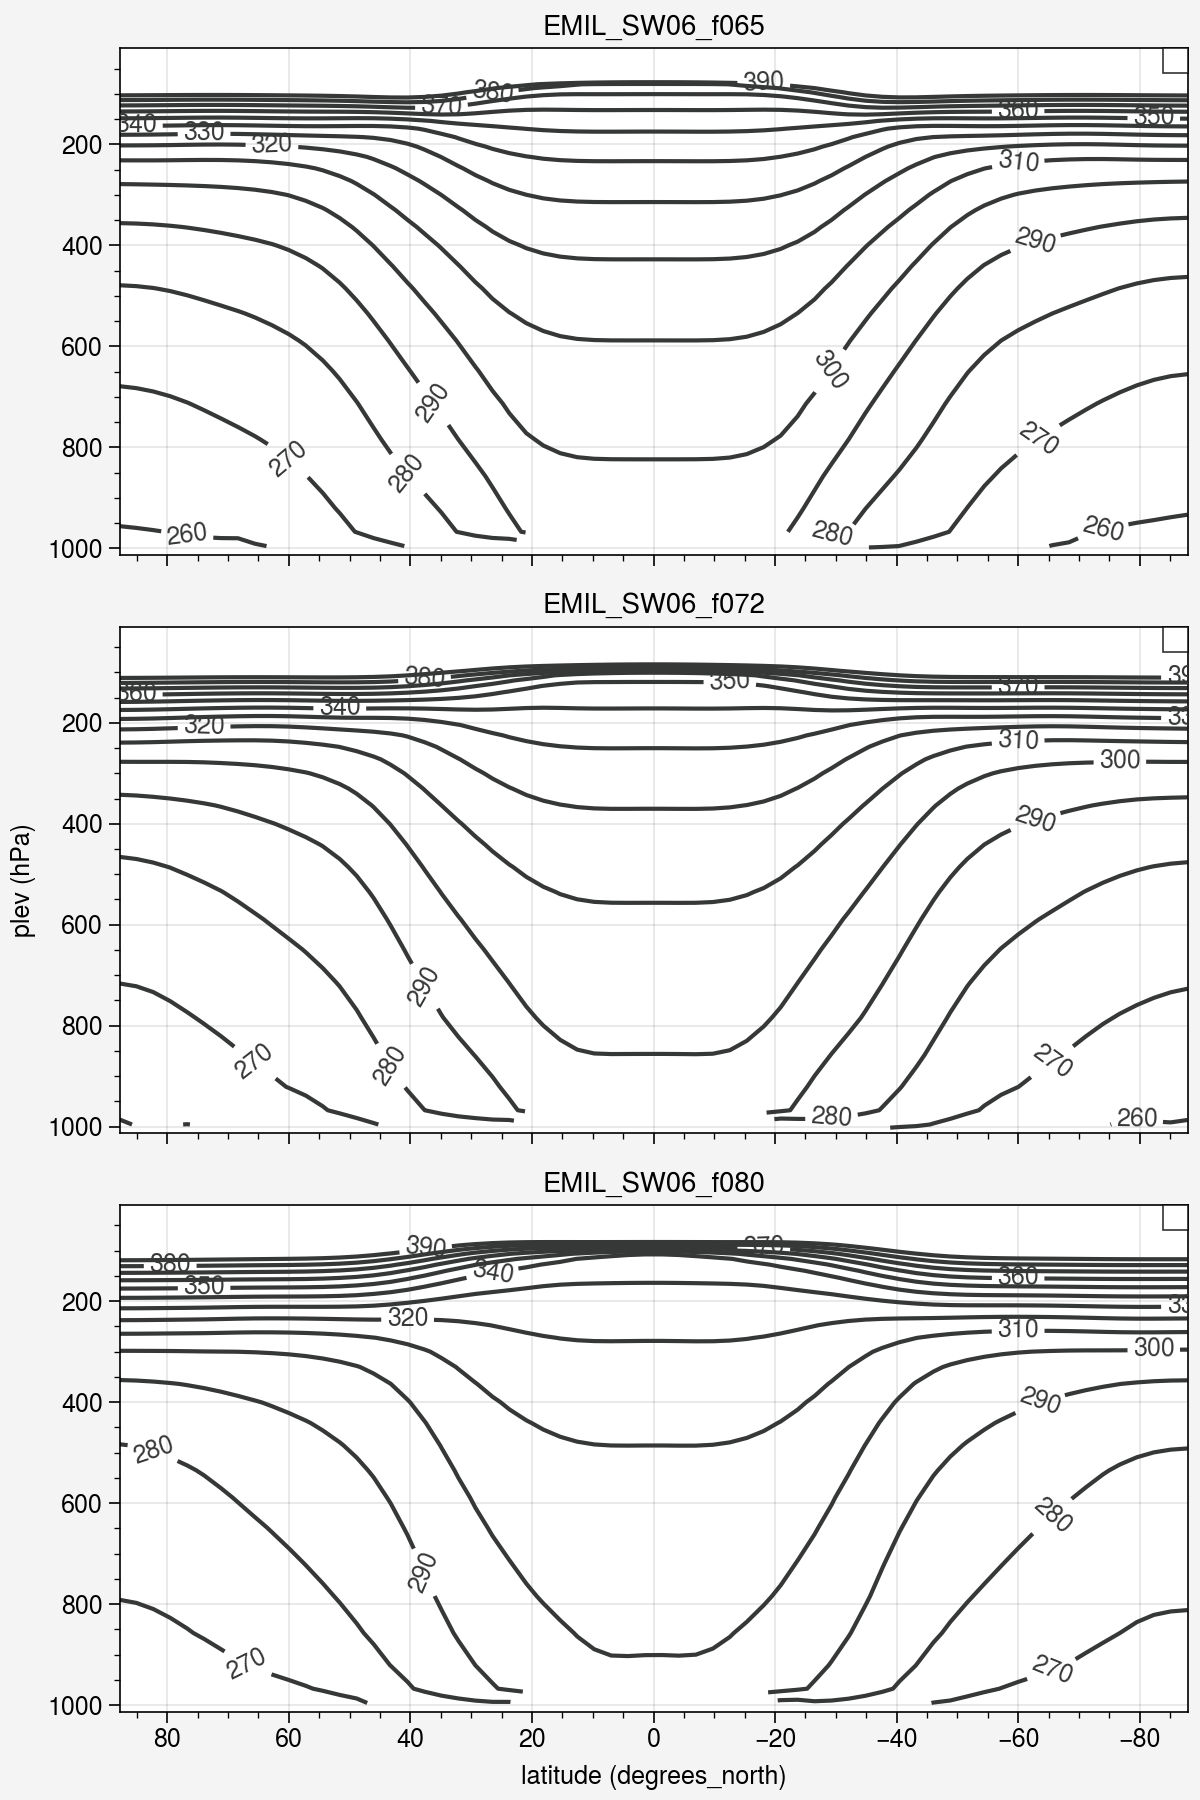

In [18]:
exp_name_sel = exp_names[::3]
fig, ax = pplt.subplots(figsize=(6,3*len(exp_name_sel)), nrows=len(exp_name_sel))

for i,exp_name in enumerate(exp_name_sel):
    
    ds = ds_zm.sel(exp_name=exp_name, plev=slice(20, 1013)).mean('time')
    ty = get_ty_from(exp_name)
    levels=np.arange(220, 390.1, 10)
    
    ax[i].contour(ds.lat, ds.plev, ds.theta, 
               color='dark gray', #alpha = 0.5 + 0.5*ty/100,
               levels=levels, labels=True, label=exp_name[-4:])
    ax[i].set_title(exp_name)

for a in ax:
    a.set_ylim(ylims)
    a.legend()
    
fig.savefig(f'Intercomparison_theta_fields.{plot_format}')

['EMIL_SW06_f065', 'EMIL_SW06_f072', 'EMIL_SW06_f080']


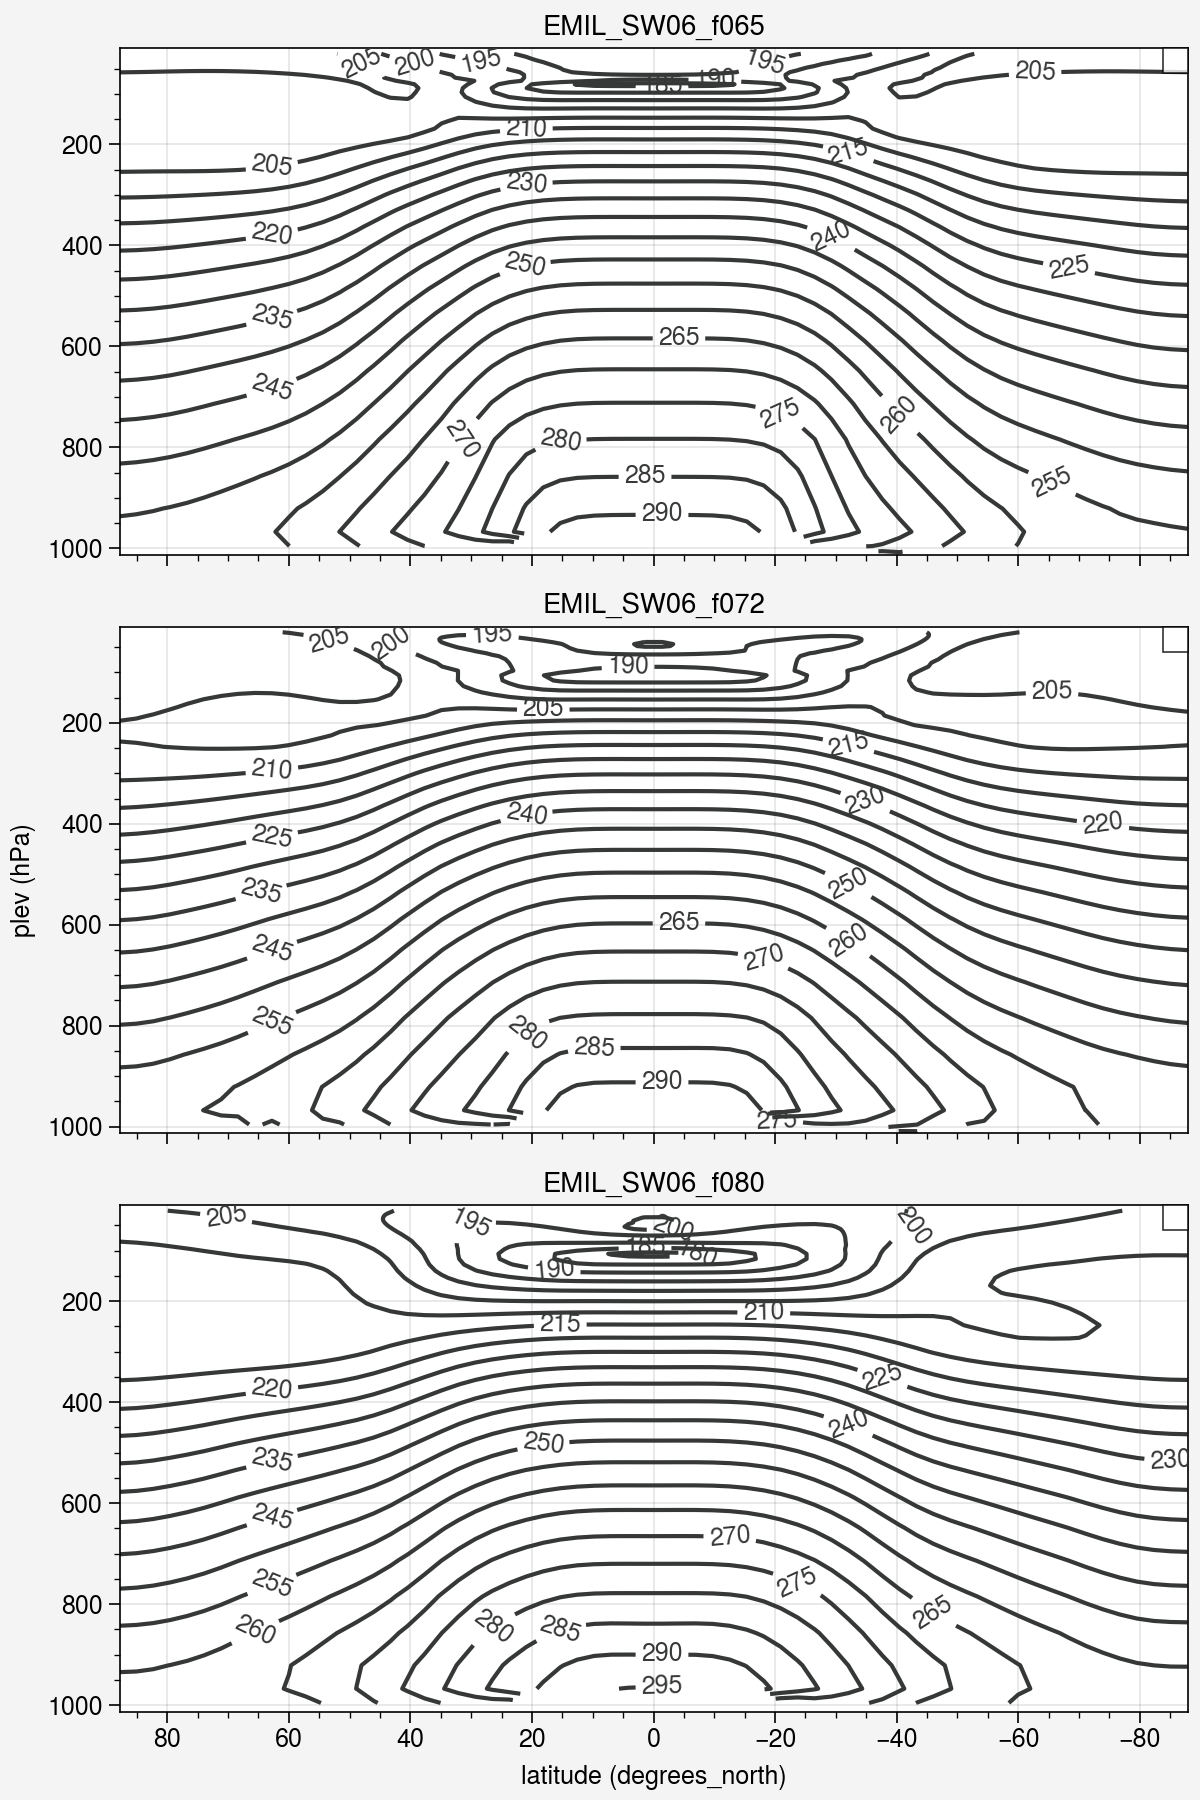

In [19]:
exp_name_sel = exp_names[::3]
print(exp_name_sel)
fig, ax = pplt.subplots(figsize=(6,3*len(exp_name_sel)), nrows=len(exp_name_sel))

for i,exp_name in enumerate(exp_name_sel):
    
    ds = ds_zm.sel(exp_name=exp_name, plev=slice(20, 1013)).mean('time')
    ty = get_ty_from(exp_name)
    levels=np.arange(180, 320.1, 5)
    
    ax[i].contour(ds.lat, ds.plev, ds.tm1, 
               color='dark gray', #alpha = 0.5 + 0.5*ty/100,
               levels=levels, labels=True, label=exp_name[-4:])
    ax[i].set_title(exp_name)

for a in ax:
    a.set_ylim(ylims)
    a.legend()
    
fig.savefig(f'Intercomparison_temperature_fields.{plot_format}')